In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import time
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, confusion_matrix, precision_recall_fscore_support, ConfusionMatrixDisplay
from torchmetrics import Accuracy
import random

In [2]:
torch.manual_seed(2023)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
train = pd.read_csv(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\train.csv')
test = pd.read_csv(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\test.csv')

X_train = train.text
y_train = train.sentiment

## Split dataset

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, shuffle=True, test_size=0.1, random_state=42)

## Synthetic Data

In [5]:
# # Synthetic Data Creation
# import nltk
# from nltk.corpus import wordnet
# 
# np.random.seed(2023)
# 
# nltk.download('punkt_tab')
# nltk.download('averaged_perceptron_tagger_eng')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
# 
# def synonym_replacement(sentence):
#     words = nltk.word_tokenize(sentence)
#     pos_tags = nltk.pos_tag(words)
# 
#     new_words = []
#     for word, tag in pos_tags:
#         synsets = wordnet.synsets(word, pos=wordnet_tag(tag))
#         if synsets:
#             synonyms = [lemma.name() for synset in synsets for lemma in synset.lemmas()]
#             synonym = np.random.choice(synonyms) if synonyms else word
#             new_words.append(synonym)
#         else:
#             new_words.append(word)
#     return ' '.join(new_words)
# 
# def wordnet_tag(tag):
#     if tag.startswith('N'):
#         return wordnet.NOUN
#     elif tag.startswith('V'):
#         return wordnet.VERB
#     elif tag.startswith('J'):
#         return wordnet.ADJ
#     elif tag.startswith('R'):
#         return wordnet.ADV
#     else:
#         return None
# 
# for itr, row in enumerate(X_train):
#     print(row)
#     print(synonym_replacement(row))
#     break
# # Add synonym replaced sentences to X_train and update y_train
# X_train_synth = []
# y_train_synth = []
# 
# for itr, row in enumerate(X_train):
#     X_train_synth.append(row)
#     # Add synthetic row
#     X_train_synth.append(synonym_replacement(row))
#     # append the true y-value twice. Once for the real row, and once for the same synth row
#     y_train_synth.append(y_train[itr])
#     y_train_synth.append(y_train[itr])

In [6]:
# to_categorical has to take values 0-n not 1-n
y_train = [x-1 for x in y_train]
y_test = [x-1 for x in y_test]

# Binaryize labels depending on whether label is 3 or not
y_train_binary = [0 if x != 3 else 1 for x in y_train]
y_test_binary = [0 if x != 3 else 1 for x in y_test]

## Tokenize

In [7]:
# Preprocess text
# Create tokenizer
tokenizer = Tokenizer()
# fit the tokenizer on the documents
tokenizer.fit_on_texts(X_train)

# define vocabulary size (largest integer value)
vocab_size = len(tokenizer.word_index) + 1

# sequence encode
encoded_train = tokenizer.texts_to_sequences(X_train)

# pad sequences
# max_length will be a tunable hyperparameter
max_length = 200
X_train = pad_sequences(encoded_train, maxlen=max_length, padding='post')

# Preprocess test set
# sequence encode
encoded_test = tokenizer.texts_to_sequences(X_test)

# pad sequences
X_test = pad_sequences(encoded_test, maxlen=max_length, padding='post')

### Convert to PyTorch Tensor

In [8]:
# convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.long).to(device)
X_test = torch.tensor(X_test, dtype=torch.long).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)
y_train_binary = torch.tensor(y_train_binary, dtype=torch.long).to(device)
y_test_binary = torch.tensor(y_test_binary, dtype=torch.long).to(device)

In [9]:
# Create dataloader for batching
batch_size = 64

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_binary_dataset = TensorDataset(X_train, y_train_binary)
test_binary_dataset = TensorDataset(X_test, y_test_binary)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
train_dataloader_for_concat_function = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader_for_concat_function = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
train_binary_dataloader = DataLoader(train_binary_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_binary_dataloader = DataLoader(test_binary_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [10]:
for image, val in train_dataloader:
    print(image.shape)
    break

torch.Size([64, 200])


## Glove pretrained embeddings

In [11]:
# Load pretrained glove twitter embeddings
import gensim

# Keep commented out since this load takes a while. Save it to disk for quicker use
# model = gensim.models.KeyedVectors.load_word2vec_format(r'C:\Users\connor\PycharmProjects\rice\comp_647\assignment_2\pretrained_embeddings\glove.twitter.27B.200d_wv.txt')
# model.save(r'C:\Users\connor\PycharmProjects\rice\comp_647\assignment_2\pretrained_embeddings\glove.twitter.27B.200d_usable_weights')
model = gensim.models.KeyedVectors.load(
    r'C:\Users\connor\PycharmProjects\rice\comp_647\assignment_2\pretrained_embeddings\glove.twitter.27B.200d_usable_weights')
weights = torch.FloatTensor(model.vectors)
embedding = nn.Embedding.from_pretrained(weights, freeze=True)

## CNN Model

In [12]:
class CNN(nn.Module):
    def __init__(self, cnn_num_classes=5, dropout_rate=0, batch_norm=False, num_linear_layers=3, num_neurons=16, num_cnn_layers=3, num_filters=32, activation_function=nn.ReLU(), pretrained_embedding=False, binary=False):
        super().__init__()
        
        # feature extraction
        if pretrained_embedding:
            self.embedding = embedding
        else:
            self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=max_length)
        self.cnn = nn.Conv1d(in_channels=max_length, out_channels=num_filters, kernel_size=3, padding='same')
        self.cnn_multi = nn.Conv1d(in_channels=max_length + 1, out_channels=num_filters, kernel_size=3, padding='same')
        self.flatten = nn.Flatten()
        # first and last linear layer and other one use layers
        self.linear = nn.Linear(in_features=max_length*num_filters, out_features=num_neurons)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.output = nn.Linear(in_features=num_neurons, out_features=cnn_num_classes)
        self.output_binary = nn.Linear(in_features=num_neurons, out_features=2)
        self.activation_function = activation_function
        self.batch_normalization = nn.BatchNorm1d(num_features=num_neurons)
        
        # layer lists
        self.dropout_list = nn.ModuleList([nn.Dropout(dropout_rate) for dummy in range(num_linear_layers-1)])
        self.batch_normalization_list = nn.ModuleList([nn.BatchNorm1d(num_features=num_neurons) for dummy in range(num_linear_layers-1)])
        self.hidden_layers_list = nn.ModuleList([nn.Linear(num_neurons, num_neurons) for dummy in range(num_linear_layers-1)])
        self.hidden_cnn_layers_list = nn.ModuleList([nn.Conv1d(in_channels=num_filters, out_channels=num_filters, kernel_size=3, padding='same') for dummy in range(num_cnn_layers-1)])
        
        # parameters used in forward function
        self.num_linear_layers = num_linear_layers
        self.num_cnn_layers = num_cnn_layers
        self.batch_norm = batch_norm
        self.binary = binary
        
    def forward(self, x, augmented_input=False):
        x = self.embedding(x)
        if augmented_input:
            x = self.cnn_multi(x)
        else:
            x = self.cnn(x)
        for layer in range(self.num_cnn_layers-1):
            x = self.hidden_cnn_layers_list[layer](x)
        x = self.flatten(x)
        if self.batch_norm:
            x = self.dropout(self.activation_function(self.batch_normalization(self.linear(x))))
        else:
            x = self.dropout(self.activation_function(self.linear(x)))
        for layer in range(self.num_linear_layers-1):
            if self.batch_norm:
                x = self.dropout_list[layer](self.activation_function(self.batch_normalization_list[layer](self.hidden_layers_list[layer](x))))
            else:
                x = self.dropout_list[layer](self.activation_function(self.hidden_layers_list[layer](x)))
        if self.binary:
            x = self.output_binary(x)
        else:
            x = self.output(x)
        return x

## Functions

In [13]:
def trainable_parameters_count(model):
    return sum(param.numel() for param in model.parameters() if param.requires_grad)

In [14]:
def train_model(network, loss_function, model_optimizer, model_num_epochs, network_name, num_classes=5, early_stopping_patience=10, cnn=True, short_training=False, train_loader=train_dataloader, test_loader=test_dataloader, binary=False, additional_train_input=None, additional_test_input=None):
    start_time = time.time()
    epoch_train_loss_list = []
    epoch_train_accuracy_list = []
    epoch_valid_loss_list = []
    epoch_valid_accuracy_list = []
    
    if binary:
        num_classes = 2
    
    # create new train loader if there is additional data to be considered
    if additional_train_input is not None:
        # There might be an error with shuffling and applying the right prediction to the
        # train loader
        additional_input = additional_train_input.view([len(additional_train_input), 1])
        X_train_temp = X_train[0: len(additional_input), :].view([len(additional_input), -1])
        # print('X train shape', X_train[0: len(additional_input), :].shape)
        X_train_additional_input = torch.cat([X_train_temp, additional_input], dim=1)
        augmented_train_dataloader = TensorDataset(X_train_additional_input, y_train[0: len(X_train_additional_input)])
        train_loader = DataLoader(augmented_train_dataloader, batch_size=batch_size, shuffle=True, drop_last=False)
        
        # There might be an error with shuffling and applying the right prediction to the
        # valid loader
        additional_input = additional_test_input.view([len(additional_test_input), 1])
        X_train_temp = X_train[0: len(additional_input), :].view([len(additional_input), -1])
        X_train_additional_input = torch.cat([X_train_temp, additional_input], dim=1)
        augmented_train_dataloader = TensorDataset(X_train_additional_input, y_train[0: len(X_train_additional_input)])
        test_loader = DataLoader(augmented_train_dataloader, batch_size=batch_size, shuffle=True, drop_last=False)
       
    best_loss = np.inf
    early_stopping_counter = 0
    
    for epoch in range(model_num_epochs):
        epoch_accuracy_train = Accuracy(task="multiclass", num_classes=num_classes).to(device)
        loss_train = np.inf
        network.train()
        for images, labels in train_loader:
            # load training data into GPU
            images = images.to(device)
            labels = labels.to(device)
            # reset grad for each iteration
            model_optimizer.zero_grad()
            # forward propagate
            if additional_train_input is not None:
                outputs = network(images, True)
            else: 
                outputs = network(images, False)
            # calculate loss
            loss_train = loss_function(outputs, labels)
            # calculate epoch accuracy
            epoch_accuracy_train(outputs, labels)
            # back propagate
            loss_train.backward()
            model_optimizer.step()
            
            # for quickly iterating model design break after 1 batch
            if short_training:
                break

        epoch_train_loss_list.append(loss_train.item())
        epoch_train_accuracy_list.append(epoch_accuracy_train.compute())
        
        # epoch validation score
        epoch_accuracy_valid = Accuracy(task="multiclass", num_classes=num_classes).to(device)
        network.eval()
        loss_valid = np.inf
        with torch.no_grad():
            for images, labels in test_loader:
                output_tensor = None
                test_tensor = None
                images = images.to(device)
                labels = labels.to(device)
                model_optimizer.zero_grad()
                if additional_train_input is not None:
                    outputs = network(images, True)
                    if output_tensor is None:
                        output_tensor = outputs
                        test_tensor = labels
                    else:
                        # Concatenate the output to the existing tensor
                        output_tensor = torch.cat((output_tensor, outputs), dim=0)
                        test_tensor = torch.cat((test_tensor, outputs), dim=0)
                else: 
                    outputs = network(images, False)
                    if output_tensor is None:
                        output_tensor = outputs
                        test_tensor = labels
                    else:
                        # Concatenate the output to the existing tensor
                        output_tensor = torch.cat((output_tensor, outputs), dim=0)
                        test_tensor = torch.cat((test_tensor, outputs), dim=0)
                loss_valid = loss_function(outputs, labels)
                # store best weights
                epoch_accuracy_valid(outputs, labels)
                
                if short_training:
                    break
        if loss_valid.item() < best_loss:
                early_stopping_counter = 0
                best_loss = loss_valid.item()
                torch.save(test_tensor, fr'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\{network_name}_labels.pt')
                torch.save(output_tensor, fr'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\{network_name}_predictions.pt')
                torch.save(network.state_dict(), fr'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\{network_name}')
        epoch_valid_loss_list.append(loss_valid)
        epoch_valid_accuracy_list.append(epoch_accuracy_valid.compute())
        
        # Stop training if after early_stopping_patience epochs, validation loss does not go down
        print('Epoch:', epoch, 'Best Loss:', best_loss, 'Current Valid loss:', loss_valid.item(), 'Stop Counter:', early_stopping_counter)
        early_stopping_counter += 1
        if early_stopping_counter > early_stopping_patience:
            print("Early Stopping Triggered")
            break
    
    #convert from tensor back to numpy dtype
    epoch_valid_loss_list = [x.cpu().numpy() for x in epoch_valid_loss_list] 
    # epoch_train_loss_list = [x.cpu().numpy() for x in epoch_train_loss_list] #this doesn't need to be converted
    epoch_valid_accuracy_list = [x.cpu().numpy() for x in epoch_valid_accuracy_list] 
    epoch_train_accuracy_list = [x.cpu().numpy() for x in epoch_train_accuracy_list] 
    training_time = time.time() - start_time
    
    return epoch_train_loss_list, epoch_valid_loss_list, epoch_train_accuracy_list, epoch_valid_accuracy_list, training_time

In [15]:
def plot_loss_and_accuracy(train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list, title):
    """
    train_loss_list: list containing the loss per epoch of the training data during training
    valid_loss_list: list containing the loss of the valid dataset using the trained dataset at the end of each epoch
    """
    fig, axes = plt.subplots(nrows=2)
    fig.suptitle(title,x=.55, y=1.75, fontsize=20)
    
    axes[0].set_title('Training and Validation Loss')    
    axes[0].plot(train_loss_list, color='b', label='Training Loss')
    axes[0].plot(valid_loss_list, color='orange', label='Validation Loss')
    axes[0].legend(['Train', 'Valid'])
    axes[0].set_xlabel('Num Epoch')
    axes[0].set_ylabel('Loss')
    
    axes[1].set_title('Training and Validation Accuracy')    
    axes[1].plot(train_accuracy_list, color='b', label='Training Accuracy')
    axes[1].plot(valid_accuracy_list, color='orange', label='Validation Accuracy')
    axes[1].legend(['Train', 'Valid'])
    axes[1].set_xlabel('Num Epoch')
    axes[1].set_ylabel('Accuracy')
    
    plt.tight_layout()
    plt.subplots_adjust(top=1.5)
    
    return fig, axes

In [16]:
def plot_roc(y_preds, y_actual, roc_num_classes):
    y_preds_clone = torch.argmax(y_preds, dim=1).clone().cpu().numpy()
    y_actual_clone = y_actual.clone().cpu().numpy()
    y_actual_clone = y_actual_clone[0:len(y_preds_clone)]
    y_true_copy = label_binarize(y_actual_clone.reshape((-1,1)), classes=range(roc_num_classes))
    y_pred_copy = label_binarize(y_preds_clone.reshape((-1,1)), classes=range(roc_num_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_num in range(roc_num_classes):
        fpr[class_num], tpr[class_num], _ = roc_curve(y_true_copy[:, class_num], y_pred_copy[:, class_num])
        roc_auc[class_num] = auc(fpr[class_num], tpr[class_num])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_copy.ravel(), y_pred_copy.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for class_num in range(roc_num_classes):
        plt.plot(fpr[class_num], tpr[class_num], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(class_num, roc_auc[class_num]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Model ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [17]:
def concat_binary_output(model, train_dataloader):
    outputs = []
    model.eval()
    with torch.no_grad():
        for images, _ in train_dataloader:
            outputs.append(model(images, False))

    outputs = torch.cat(outputs, dim=0)
    outputs = torch.tensor(outputs, dtype=torch.long)
    return torch.argmax(outputs, dim=1)

In [18]:
## Random Grid Search Func
def random_grid_search(architecture_type, lr_list, activation_function_list, neuron_num_list, batch_norm_list, dropout_rate_list, cnn_num_layers_list, linear_num_layers_list, filters_list, num_epochs, early_stop_num, num_classes, num_combos=5, seed_value=None):
    # set seed for reproducibility
    random.seed(seed_value)
    
    best_model_loss = np.inf
    best_rand_grid_model = None
    # randomly choose combo
    for dummy in range(num_combos):
        lr = random.choice(lr_list)
        activation = random.choice(activation_function_list)
        neuron_num = random.choice(neuron_num_list)
        batch_norm_t_f = random.choice(batch_norm_list)
        dropout = random.choice(dropout_rate_list)
        num_cnn_layers = random.choice(cnn_num_layers_list)
        num_linear_layers = random.choice(linear_num_layers_list)
        num_filters = random.choice(filters_list)
        
        network_name = 'cnn_num_classes_' + str(num_classes) + '_dropout_rate_' + str(dropout) + '_batch_norm_' + str(batch_norm_t_f) + '_num_linear_layers_' + str(num_linear_layers) + '_num_neurons_' + str(neuron_num) + '_num_cnn_layers_' + str(num_cnn_layers) + '_num_filters_' + str(num_filters) + '_activation_function_' + str(activation) + '_' + str(architecture_type)
        
        if architecture_type == 'binary and multi classifier':
            # build binary classifier first 
            # cnn_binary = CNN(cnn_num_classes=num_classes, dropout_rate=dropout, batch_norm=batch_norm_t_f, num_linear_layers=num_linear_layers, num_neurons=neuron_num, num_cnn_layers=num_cnn_layers, num_filters=num_filters, activation_function=activation, pretrained_embedding=True, binary=True)
            # cnn_binary.to(device)
            # loss_binary = nn.CrossEntropyLoss()
            # optimizer_binary = torch.optim.Adam(cnn_binary.parameters(), lr=lr)
            # train_loss, valid_loss, train_acc, valid_acc, cnn_model_train_time = train_model(cnn_binary, loss_function=loss_binary, model_optimizer=optimizer_binary, model_num_epochs=num_epochs, cnn=True, short_training=False, early_stopping_patience=early_stop_num, network_name=network_name + '_binary', train_loader=train_binary_dataloader, test_loader=test_binary_dataloader, binary=True, additional_train_input=None, additional_test_input=None)
            # print('Network Name:', network_name, 'binary', 'Trainable Parameters:', trainable_parameters_count(cnn_binary))
            # # plot training and validation loss as well as accuracy for both
            # plot_loss_and_accuracy(train_loss, valid_loss, train_acc, valid_acc, title=network_name)
            
            
            # concat binary output to multiclass input
            # use pretrained binary classifier
            cnn_binary = CNN(cnn_num_classes=5, dropout_rate=.2, batch_norm=False, num_linear_layers=3, num_neurons=32, num_cnn_layers=3, num_filters=16, activation_function=nn.LeakyReLU(), pretrained_embedding=True, binary=True)
            cnn_binary.to(device)
            cnn_binary.load_state_dict(torch.load(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\cnn_num_classes_5_dropout_rate_0.2_batch_norm_False_num_linear_layers_3_num_neurons_32_num_cnn_layers_3_num_filters_16_activation_function_LeakyReLU(negative_slope=0.01)_binary and multi classifier_binary', weights_only=True))
            
            train_binary_output = concat_binary_output(cnn_binary, train_dataloader_for_concat_function)
            test_binary_output = concat_binary_output(cnn_binary, test_dataloader_for_concat_function)
            # build multiclass second
            cnn_multi = CNN(cnn_num_classes=num_classes, dropout_rate=dropout, batch_norm=batch_norm_t_f, num_linear_layers=num_linear_layers, num_neurons=neuron_num, num_cnn_layers=num_cnn_layers, num_filters=num_filters, activation_function=activation, pretrained_embedding=True, binary=False)
            cnn_multi.to(device)
            loss_multi = nn.CrossEntropyLoss()
            optimizer_multi = torch.optim.Adam(cnn_multi.parameters(), lr=lr)
            train_loss, valid_loss, train_acc, valid_acc, cnn_model_train_time = train_model(cnn_multi, loss_function=loss_multi, model_optimizer=optimizer_multi, model_num_epochs=num_epochs, cnn=True, short_training=False, early_stopping_patience=early_stop_num, network_name=network_name + '_multi', train_loader=train_dataloader, test_loader=test_dataloader, binary=False, additional_train_input=train_binary_output, additional_test_input=test_binary_output)
        
        print('Network Name:', network_name, 'multi', 'Trainable Parameters:', trainable_parameters_count(cnn_multi))
        # plot training and validation loss as well as accuracy for both
        plot_loss_and_accuracy(train_loss, valid_loss, train_acc, valid_acc, title=network_name)
        y_test = torch.load(fr'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\{network_name}_multi_labels.pt', weights_only=True) 
        y_preds = torch.load(fr'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\{network_name}_multi_predictions.pt', weights_only=True) 
        #plot_roc(y_preds, y_test, 5)
        y_test_copy = y_test.clone().cpu().numpy()[0:len(y_preds)].astype(int)
        y_pred_copy = np.argmax(y_preds.clone().cpu().numpy().astype(int), axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test_copy, y_pred_copy, average='weighted')
        cm = confusion_matrix(y_test_copy, y_pred_copy)
        print('y_test', y_test)
        print('y_preds', y_preds)
        ConfusionMatrixDisplay(cm).plot()
        # keep track of which model had the lowest loss of all models. This model is saved as network_name in the model_weights directory
        min_valid_loss = np.inf
        for val in valid_loss:
            if val < min_valid_loss:
                min_valid_loss = val
                
        if min_valid_loss < best_model_loss:
            best_model_loss = min_valid_loss
            best_rand_grid_model = network_name
            
    return best_rand_grid_model

## Build Models

In [19]:
# parameter tuning
architecture_type = 'binary and multi classifier'
lr_list = [.0001, .00001, .000001, .0000001]
activation_function_list = [nn.ReLU(), nn.LeakyReLU(), nn.Softmax(dim=0)]
neuron_num_list = [16, 32, 64, 128]
batch_norm_list = [True, False]
dropout_rate_list = [.1, .2, .5, .75]
cnn_num_layers_list = [3,4]
linear_num_layers_list = [3,4,5]
filters_list = [16,32,64]
num_epochs = 250
early_stop_num = 20
num_classes = 5
num_combos = 20
seed_value = 100

C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6136800050735474 Current Valid loss: 1.6136800050735474 Stop Counter: 0
Epoch: 1 Best Loss: 1.6136800050735474 Current Valid loss: 1.6246336698532104 Stop Counter: 1
Epoch: 2 Best Loss: 1.6136800050735474 Current Valid loss: 1.6228893995285034 Stop Counter: 2
Epoch: 3 Best Loss: 1.6136800050735474 Current Valid loss: 1.6147059202194214 Stop Counter: 3
Epoch: 4 Best Loss: 1.6136800050735474 Current Valid loss: 1.6211313009262085 Stop Counter: 4
Epoch: 5 Best Loss: 1.6136800050735474 Current Valid loss: 1.615088701248169 Stop Counter: 5
Epoch: 6 Best Loss: 1.6135342121124268 Current Valid loss: 1.6135342121124268 Stop Counter: 0
Epoch: 7 Best Loss: 1.607886791229248 Current Valid loss: 1.607886791229248 Stop Counter: 0
Epoch: 8 Best Loss: 1.607886791229248 Current Valid loss: 1.6105057001113892 Stop Counter: 1
Epoch: 9 Best Loss: 1.6052738428115845 Current Valid loss: 1.6052738428115845 Stop Counter: 0
Epoch: 10 Best Loss: 1.6052738428115845 Current Valid loss: 1.61

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_test tensor([2, 2, 2, 2, 3, 3, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2,
        2, 2, 3, 2, 2, 0, 3, 2, 2, 2, 0, 2, 4, 2, 1, 2, 3, 2, 1, 3, 2, 2, 2, 3,
        3, 4, 3, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
y_preds tensor([[-0.1452, -0.1721,  0.2451,  0.0148, -0.1508],
        [-0.1456, -0.1706,  0.1377,  0.1066, -0.2169],
        [-0.1577, -0.1649,  0.2275,  0.0551, -0.1473],
        [-0.0951, -0.0861,  0.2386,  0.0586, -0.1697],
        [-0.1245, -0.0905,  0.2104,  0.0716, -0.1828],
        [-0.1186, -0.1403,  0.1747,  0.0295, -0.2110],
        [-0.1068, -0.1327,  0.1633,  0.0529, -0.1799],
        [-0.1687, -0.1138,  0.1669,  0.0438, -0.1512],
        [-0.1621, -0.1555,  0.2617,  0.0375, -0.1895],
        [-0.0915, -0.1187,  0.1619,  0.0917, -0.1903],
        [-0.1151, -0.1485,  0.1902,  0.0618, -0.1546],
        [-0.1330, -0.0930,  0.1842,  0.0943, -0.2002],
        [-0.1508, -0.2374,  0.1924,  0.0380, -0.1883],
        [-0.2056, -0.1676,  0.2881, 

C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6963000297546387 Current Valid loss: 1.6963000297546387 Stop Counter: 0
Epoch: 1 Best Loss: 1.6948637962341309 Current Valid loss: 1.6948637962341309 Stop Counter: 0
Epoch: 2 Best Loss: 1.6934552192687988 Current Valid loss: 1.6934552192687988 Stop Counter: 0
Epoch: 3 Best Loss: 1.6920424699783325 Current Valid loss: 1.6920424699783325 Stop Counter: 0
Epoch: 4 Best Loss: 1.690666675567627 Current Valid loss: 1.690666675567627 Stop Counter: 0
Epoch: 5 Best Loss: 1.6892389059066772 Current Valid loss: 1.6892389059066772 Stop Counter: 0
Epoch: 6 Best Loss: 1.6886730194091797 Current Valid loss: 1.6886730194091797 Stop Counter: 0
Epoch: 7 Best Loss: 1.6871801614761353 Current Valid loss: 1.6871801614761353 Stop Counter: 0
Epoch: 8 Best Loss: 1.6847991943359375 Current Valid loss: 1.6847991943359375 Stop Counter: 0
Epoch: 9 Best Loss: 1.683531641960144 Current Valid loss: 1.683531641960144 Stop Counter: 0
Epoch: 10 Best Loss: 1.6825789213180542 Current Valid loss: 1.68

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6628144979476929 Current Valid loss: 1.6628144979476929 Stop Counter: 0
Epoch: 1 Best Loss: 1.65895676612854 Current Valid loss: 1.65895676612854 Stop Counter: 0
Epoch: 2 Best Loss: 1.6546051502227783 Current Valid loss: 1.6546051502227783 Stop Counter: 0
Epoch: 3 Best Loss: 1.6505426168441772 Current Valid loss: 1.6505426168441772 Stop Counter: 0
Epoch: 4 Best Loss: 1.6473402976989746 Current Valid loss: 1.6473402976989746 Stop Counter: 0
Epoch: 5 Best Loss: 1.643730878829956 Current Valid loss: 1.643730878829956 Stop Counter: 0
Epoch: 6 Best Loss: 1.639827013015747 Current Valid loss: 1.639827013015747 Stop Counter: 0
Epoch: 7 Best Loss: 1.6347018480300903 Current Valid loss: 1.6347018480300903 Stop Counter: 0
Epoch: 8 Best Loss: 1.6269104480743408 Current Valid loss: 1.6269104480743408 Stop Counter: 0
Epoch: 9 Best Loss: 1.6178017854690552 Current Valid loss: 1.6178017854690552 Stop Counter: 0
Epoch: 10 Best Loss: 1.6082409620285034 Current Valid loss: 1.608240

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_test tensor([2, 3, 2, 1, 2, 4, 2, 1, 0, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 1, 2, 2, 2,
        1, 2, 2, 2, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 2, 1, 2, 2,
        2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 2, 2, 3, 1, 0, 2], device='cuda:0')
y_preds tensor([[-1.1226, -0.0371,  1.4538,  0.5021, -0.5640],
        [-1.1261, -0.0383,  1.4602,  0.5045, -0.5660],
        [-1.1124, -0.0393,  1.4424,  0.4974, -0.5596],
        [-1.1095, -0.0382,  1.4371,  0.4970, -0.5579],
        [-1.1669, -0.0374,  1.5160,  0.5217, -0.5848],
        [-1.1282, -0.0373,  1.4644,  0.5053, -0.5671],
        [-1.1312, -0.0376,  1.4681,  0.5064, -0.5684],
        [-1.1567, -0.0368,  1.5001,  0.5174, -0.5800],
        [-1.1446, -0.0372,  1.4847,  0.5124, -0.5748],
        [-1.1216, -0.0392,  1.4552,  0.5020, -0.5639],
        [-1.1284, -0.0381,  1.4646,  0.5052, -0.5676],
        [-1.1129, -0.0384,  1.4407,  0.4973, -0.5587],
        [-1.1362, -0.0382,  1.4754,  0.5088, -0.5712],
        [-1.1227, -0.0381,  1.4575, 

C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6192779541015625 Current Valid loss: 1.6192779541015625 Stop Counter: 0
Epoch: 1 Best Loss: 1.6078191995620728 Current Valid loss: 1.6078191995620728 Stop Counter: 0
Epoch: 2 Best Loss: 1.6078191995620728 Current Valid loss: 1.6233670711517334 Stop Counter: 1
Epoch: 3 Best Loss: 1.6078191995620728 Current Valid loss: 1.614984154701233 Stop Counter: 2
Epoch: 4 Best Loss: 1.6078191995620728 Current Valid loss: 1.61273992061615 Stop Counter: 3
Epoch: 5 Best Loss: 1.6078191995620728 Current Valid loss: 1.607907772064209 Stop Counter: 4
Epoch: 6 Best Loss: 1.6078191995620728 Current Valid loss: 1.615789532661438 Stop Counter: 5
Epoch: 7 Best Loss: 1.6078191995620728 Current Valid loss: 1.6223225593566895 Stop Counter: 6
Epoch: 8 Best Loss: 1.6078191995620728 Current Valid loss: 1.6259647607803345 Stop Counter: 7
Epoch: 9 Best Loss: 1.6078191995620728 Current Valid loss: 1.6155288219451904 Stop Counter: 8
Epoch: 10 Best Loss: 1.6078191995620728 Current Valid loss: 1.615

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.5993565320968628 Current Valid loss: 1.5993565320968628 Stop Counter: 0
Epoch: 1 Best Loss: 1.5993565320968628 Current Valid loss: 1.6019452810287476 Stop Counter: 1
Epoch: 2 Best Loss: 1.5993565320968628 Current Valid loss: 1.5994378328323364 Stop Counter: 2
Epoch: 3 Best Loss: 1.5993565320968628 Current Valid loss: 1.6153866052627563 Stop Counter: 3
Epoch: 4 Best Loss: 1.5993565320968628 Current Valid loss: 1.619626760482788 Stop Counter: 4
Epoch: 5 Best Loss: 1.5993565320968628 Current Valid loss: 1.6070823669433594 Stop Counter: 5
Epoch: 6 Best Loss: 1.596454381942749 Current Valid loss: 1.596454381942749 Stop Counter: 0
Epoch: 7 Best Loss: 1.5701720714569092 Current Valid loss: 1.5701720714569092 Stop Counter: 0
Epoch: 8 Best Loss: 1.5640826225280762 Current Valid loss: 1.5640826225280762 Stop Counter: 0
Epoch: 9 Best Loss: 1.5636485815048218 Current Valid loss: 1.5636485815048218 Stop Counter: 0
Epoch: 10 Best Loss: 1.5636485815048218 Current Valid loss: 1.5

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.68343985080719 Current Valid loss: 1.68343985080719 Stop Counter: 0
Epoch: 1 Best Loss: 1.6729753017425537 Current Valid loss: 1.6729753017425537 Stop Counter: 0
Epoch: 2 Best Loss: 1.6527622938156128 Current Valid loss: 1.6527622938156128 Stop Counter: 0
Epoch: 3 Best Loss: 1.6459542512893677 Current Valid loss: 1.6459542512893677 Stop Counter: 0
Epoch: 4 Best Loss: 1.6459542512893677 Current Valid loss: 1.6511117219924927 Stop Counter: 1
Epoch: 5 Best Loss: 1.6459542512893677 Current Valid loss: 1.6467657089233398 Stop Counter: 2
Epoch: 6 Best Loss: 1.6324535608291626 Current Valid loss: 1.6324535608291626 Stop Counter: 0
Epoch: 7 Best Loss: 1.6157101392745972 Current Valid loss: 1.6157101392745972 Stop Counter: 0
Epoch: 8 Best Loss: 1.6003456115722656 Current Valid loss: 1.6003456115722656 Stop Counter: 0
Epoch: 9 Best Loss: 1.5926216840744019 Current Valid loss: 1.5926216840744019 Stop Counter: 0
Epoch: 10 Best Loss: 1.5926216840744019 Current Valid loss: 1.59

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.7145321369171143 Current Valid loss: 1.7145321369171143 Stop Counter: 0
Epoch: 1 Best Loss: 1.7143858671188354 Current Valid loss: 1.7143858671188354 Stop Counter: 0
Epoch: 2 Best Loss: 1.7142404317855835 Current Valid loss: 1.7142404317855835 Stop Counter: 0
Epoch: 3 Best Loss: 1.7140944004058838 Current Valid loss: 1.7140944004058838 Stop Counter: 0
Epoch: 4 Best Loss: 1.7139489650726318 Current Valid loss: 1.7139489650726318 Stop Counter: 0
Epoch: 5 Best Loss: 1.7138036489486694 Current Valid loss: 1.7138036489486694 Stop Counter: 0
Epoch: 6 Best Loss: 1.7136582136154175 Current Valid loss: 1.7136582136154175 Stop Counter: 0
Epoch: 7 Best Loss: 1.7135084867477417 Current Valid loss: 1.7135084867477417 Stop Counter: 0
Epoch: 8 Best Loss: 1.713256597518921 Current Valid loss: 1.713256597518921 Stop Counter: 0
Epoch: 9 Best Loss: 1.7116670608520508 Current Valid loss: 1.7116670608520508 Stop Counter: 0
Epoch: 10 Best Loss: 1.7100859880447388 Current Valid loss: 1.

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6129586696624756 Current Valid loss: 1.6129586696624756 Stop Counter: 0
Epoch: 1 Best Loss: 1.6129357814788818 Current Valid loss: 1.6129357814788818 Stop Counter: 0
Epoch: 2 Best Loss: 1.612912893295288 Current Valid loss: 1.612912893295288 Stop Counter: 0
Epoch: 3 Best Loss: 1.6128896474838257 Current Valid loss: 1.6128896474838257 Stop Counter: 0
Epoch: 4 Best Loss: 1.6128673553466797 Current Valid loss: 1.6128673553466797 Stop Counter: 0
Epoch: 5 Best Loss: 1.6128445863723755 Current Valid loss: 1.6128445863723755 Stop Counter: 0
Epoch: 6 Best Loss: 1.61282217502594 Current Valid loss: 1.61282217502594 Stop Counter: 0
Epoch: 7 Best Loss: 1.6127994060516357 Current Valid loss: 1.6127994060516357 Stop Counter: 0
Epoch: 8 Best Loss: 1.6127774715423584 Current Valid loss: 1.6127774715423584 Stop Counter: 0
Epoch: 9 Best Loss: 1.6127543449401855 Current Valid loss: 1.6127543449401855 Stop Counter: 0
Epoch: 10 Best Loss: 1.6127313375473022 Current Valid loss: 1.6127

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6716848611831665 Current Valid loss: 1.6716848611831665 Stop Counter: 0
Epoch: 1 Best Loss: 1.6716629266738892 Current Valid loss: 1.6716629266738892 Stop Counter: 0
Epoch: 2 Best Loss: 1.6716450452804565 Current Valid loss: 1.6716450452804565 Stop Counter: 0
Epoch: 3 Best Loss: 1.6716272830963135 Current Valid loss: 1.6716272830963135 Stop Counter: 0
Epoch: 4 Best Loss: 1.671605110168457 Current Valid loss: 1.671605110168457 Stop Counter: 0
Epoch: 5 Best Loss: 1.6715830564498901 Current Valid loss: 1.6715830564498901 Stop Counter: 0
Epoch: 6 Best Loss: 1.6715646982192993 Current Valid loss: 1.6715646982192993 Stop Counter: 0
Epoch: 7 Best Loss: 1.6715444326400757 Current Valid loss: 1.6715444326400757 Stop Counter: 0
Epoch: 8 Best Loss: 1.6715222597122192 Current Valid loss: 1.6715222597122192 Stop Counter: 0
Epoch: 9 Best Loss: 1.6715009212493896 Current Valid loss: 1.6715009212493896 Stop Counter: 0
Epoch: 10 Best Loss: 1.6714823246002197 Current Valid loss: 1.

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6965224742889404 Current Valid loss: 1.6965224742889404 Stop Counter: 0
Epoch: 1 Best Loss: 1.696473240852356 Current Valid loss: 1.696473240852356 Stop Counter: 0
Epoch: 2 Best Loss: 1.6964221000671387 Current Valid loss: 1.6964221000671387 Stop Counter: 0
Epoch: 3 Best Loss: 1.6963694095611572 Current Valid loss: 1.6963694095611572 Stop Counter: 0
Epoch: 4 Best Loss: 1.6963163614273071 Current Valid loss: 1.6963163614273071 Stop Counter: 0
Epoch: 5 Best Loss: 1.6962616443634033 Current Valid loss: 1.6962616443634033 Stop Counter: 0
Epoch: 6 Best Loss: 1.6962071657180786 Current Valid loss: 1.6962071657180786 Stop Counter: 0
Epoch: 7 Best Loss: 1.6961523294448853 Current Valid loss: 1.6961523294448853 Stop Counter: 0
Epoch: 8 Best Loss: 1.6960996389389038 Current Valid loss: 1.6960996389389038 Stop Counter: 0
Epoch: 9 Best Loss: 1.6960461139678955 Current Valid loss: 1.6960461139678955 Stop Counter: 0
Epoch: 10 Best Loss: 1.6959936618804932 Current Valid loss: 1.

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.587973952293396 Current Valid loss: 1.587973952293396 Stop Counter: 0
Epoch: 1 Best Loss: 1.5879560708999634 Current Valid loss: 1.5879560708999634 Stop Counter: 0
Epoch: 2 Best Loss: 1.5879393815994263 Current Valid loss: 1.5879393815994263 Stop Counter: 0
Epoch: 3 Best Loss: 1.58792245388031 Current Valid loss: 1.58792245388031 Stop Counter: 0
Epoch: 4 Best Loss: 1.587904453277588 Current Valid loss: 1.587904453277588 Stop Counter: 0
Epoch: 5 Best Loss: 1.5878877639770508 Current Valid loss: 1.5878877639770508 Stop Counter: 0
Epoch: 6 Best Loss: 1.5878702402114868 Current Valid loss: 1.5878702402114868 Stop Counter: 0
Epoch: 7 Best Loss: 1.5878535509109497 Current Valid loss: 1.5878535509109497 Stop Counter: 0
Epoch: 8 Best Loss: 1.5878362655639648 Current Valid loss: 1.5878362655639648 Stop Counter: 0
Epoch: 9 Best Loss: 1.5878193378448486 Current Valid loss: 1.5878193378448486 Stop Counter: 0
Epoch: 10 Best Loss: 1.5878024101257324 Current Valid loss: 1.587802

C:\Users\connor\AppData\Local\Temp\ipykernel_27492\1109479121.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(nrows=2)
C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.te

Epoch: 0 Best Loss: 1.623484492301941 Current Valid loss: 1.623484492301941 Stop Counter: 0
Epoch: 1 Best Loss: 1.623484492301941 Current Valid loss: 1.6280955076217651 Stop Counter: 1
Epoch: 2 Best Loss: 1.604962944984436 Current Valid loss: 1.604962944984436 Stop Counter: 0
Epoch: 3 Best Loss: 1.5626499652862549 Current Valid loss: 1.5626499652862549 Stop Counter: 0
Epoch: 4 Best Loss: 1.5475876331329346 Current Valid loss: 1.5475876331329346 Stop Counter: 0
Epoch: 5 Best Loss: 1.538670301437378 Current Valid loss: 1.538670301437378 Stop Counter: 0
Epoch: 6 Best Loss: 1.501296043395996 Current Valid loss: 1.501296043395996 Stop Counter: 0
Epoch: 7 Best Loss: 1.4575697183609009 Current Valid loss: 1.4575697183609009 Stop Counter: 0
Epoch: 8 Best Loss: 1.4266881942749023 Current Valid loss: 1.4266881942749023 Stop Counter: 0
Epoch: 9 Best Loss: 1.4250996112823486 Current Valid loss: 1.4250996112823486 Stop Counter: 0
Epoch: 10 Best Loss: 1.3514336347579956 Current Valid loss: 1.3514336

C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.658951997756958 Current Valid loss: 1.658951997756958 Stop Counter: 0
Epoch: 1 Best Loss: 1.6202428340911865 Current Valid loss: 1.6202428340911865 Stop Counter: 0
Epoch: 2 Best Loss: 1.5462414026260376 Current Valid loss: 1.5462414026260376 Stop Counter: 0
Epoch: 3 Best Loss: 1.4117275476455688 Current Valid loss: 1.4117275476455688 Stop Counter: 0
Epoch: 4 Best Loss: 1.1987413167953491 Current Valid loss: 1.1987413167953491 Stop Counter: 0
Epoch: 5 Best Loss: 1.0700898170471191 Current Valid loss: 1.0700898170471191 Stop Counter: 0
Epoch: 6 Best Loss: 1.0439382791519165 Current Valid loss: 1.0439382791519165 Stop Counter: 0
Epoch: 7 Best Loss: 1.0439382791519165 Current Valid loss: 1.0499436855316162 Stop Counter: 1
Epoch: 8 Best Loss: 1.0356718301773071 Current Valid loss: 1.0356718301773071 Stop Counter: 0
Epoch: 9 Best Loss: 1.0356718301773071 Current Valid loss: 1.0382471084594727 Stop Counter: 1
Epoch: 10 Best Loss: 1.0356718301773071 Current Valid loss: 1.

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


y_test tensor([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 3, 0, 2, 2, 1, 3, 2, 3, 2, 2, 2, 2, 2, 0,
        2, 2, 4, 1, 3, 3, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 3, 1, 1, 2, 2, 2, 3, 2, 3, 2, 3, 3, 2, 4, 2], device='cuda:0')
y_preds tensor([[-1.6001, -0.3329,  1.2485,  0.0764, -0.8885],
        [-1.6324, -0.3376,  1.2761,  0.0747, -0.9081],
        [-1.6525, -0.3413,  1.2943,  0.0750, -0.9215],
        [-1.6479, -0.3383,  1.2869,  0.0741, -0.9167],
        [-1.6604, -0.3427,  1.3007,  0.0741, -0.9270],
        [-1.6220, -0.3365,  1.2680,  0.0750, -0.9024],
        [-1.6883, -0.3443,  1.3220,  0.0724, -0.9429],
        [-1.6267, -0.3359,  1.2677,  0.0753, -0.9026],
        [-1.6109, -0.3328,  1.2569,  0.0746, -0.8938],
        [-1.7197, -0.3499,  1.3490,  0.0722, -0.9621],
        [-1.6227, -0.3372,  1.2687,  0.0754, -0.9038],
        [-1.7068, -0.3483,  1.3388,  0.0724, -0.9550],
        [-1.6239, -0.3347,  1.2697,  0.0744, -0.9035],
        [-1.6334, -0.3378,  1.2768, 

C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.611577033996582 Current Valid loss: 1.611577033996582 Stop Counter: 0
Epoch: 1 Best Loss: 1.611577033996582 Current Valid loss: 1.6511116027832031 Stop Counter: 1
Epoch: 2 Best Loss: 1.611577033996582 Current Valid loss: 1.6729660034179688 Stop Counter: 2
Epoch: 3 Best Loss: 1.611577033996582 Current Valid loss: 1.6760648488998413 Stop Counter: 3
Epoch: 4 Best Loss: 1.611577033996582 Current Valid loss: 1.6555448770523071 Stop Counter: 4
Epoch: 5 Best Loss: 1.5845232009887695 Current Valid loss: 1.5845232009887695 Stop Counter: 0
Epoch: 6 Best Loss: 1.5478005409240723 Current Valid loss: 1.5478005409240723 Stop Counter: 0
Epoch: 7 Best Loss: 1.5197356939315796 Current Valid loss: 1.5197356939315796 Stop Counter: 0
Epoch: 8 Best Loss: 1.506255030632019 Current Valid loss: 1.506255030632019 Stop Counter: 0
Epoch: 9 Best Loss: 1.503204584121704 Current Valid loss: 1.503204584121704 Stop Counter: 0
Epoch: 10 Best Loss: 1.503204584121704 Current Valid loss: 1.508358597

C:\Users\connor\AppData\Local\Programs\Python\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\connor\AppData\Local\Temp\ipykernel_27492\22755565.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs, dtype=torch.long)


Epoch: 0 Best Loss: 1.6881771087646484 Current Valid loss: 1.6881771087646484 Stop Counter: 0
Epoch: 1 Best Loss: 1.688037633895874 Current Valid loss: 1.688037633895874 Stop Counter: 0
Epoch: 2 Best Loss: 1.687894344329834 Current Valid loss: 1.687894344329834 Stop Counter: 0
Epoch: 3 Best Loss: 1.6877509355545044 Current Valid loss: 1.6877509355545044 Stop Counter: 0
Epoch: 4 Best Loss: 1.6876060962677002 Current Valid loss: 1.6876060962677002 Stop Counter: 0
Epoch: 5 Best Loss: 1.6874682903289795 Current Valid loss: 1.6874682903289795 Stop Counter: 0
Epoch: 6 Best Loss: 1.6873438358306885 Current Valid loss: 1.6873438358306885 Stop Counter: 0
Epoch: 7 Best Loss: 1.687269926071167 Current Valid loss: 1.687269926071167 Stop Counter: 0
Epoch: 8 Best Loss: 1.687269926071167 Current Valid loss: 1.6876300573349 Stop Counter: 1
Epoch: 9 Best Loss: 1.6871836185455322 Current Valid loss: 1.6871836185455322 Stop Counter: 0
Epoch: 10 Best Loss: 1.686877965927124 Current Valid loss: 1.686877965

KeyboardInterrupt: 

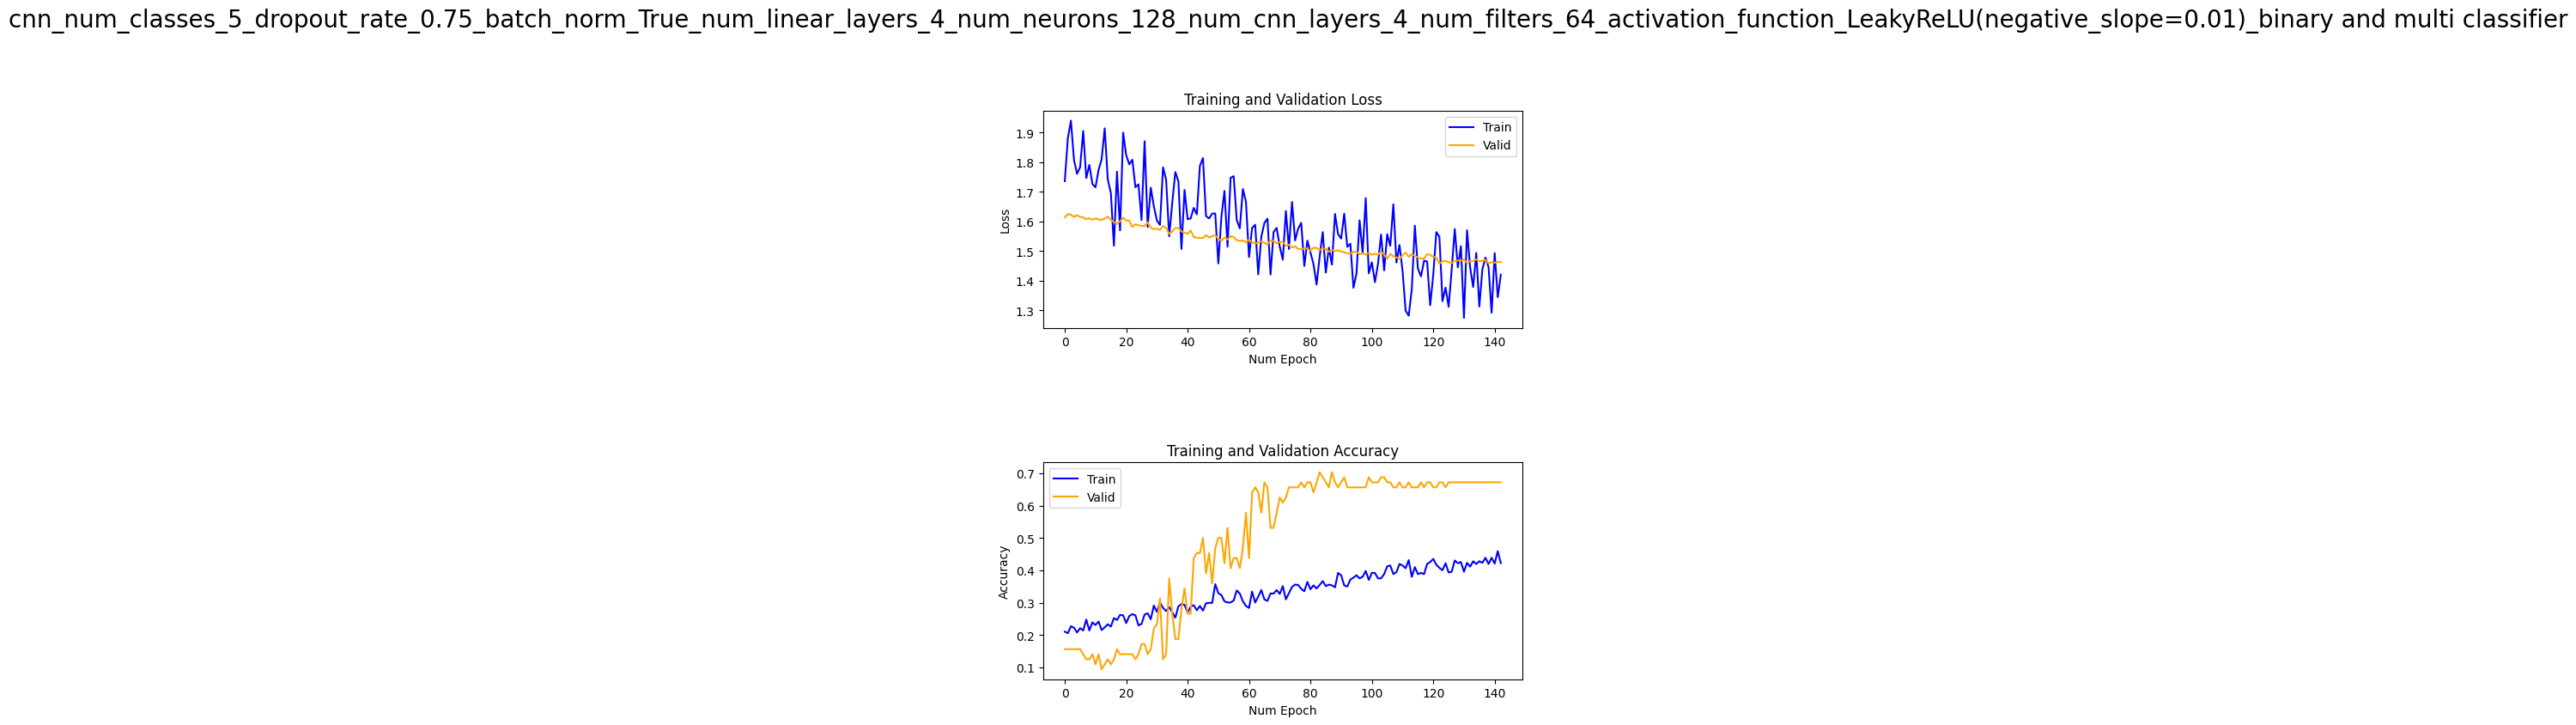

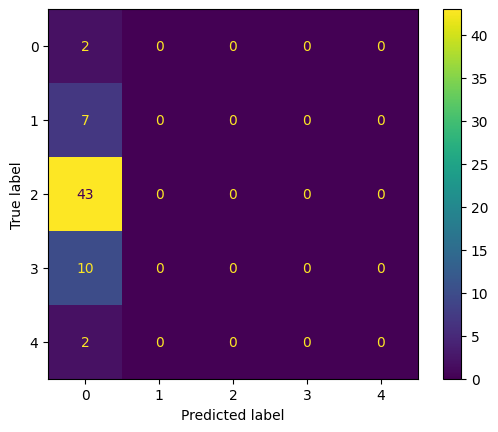

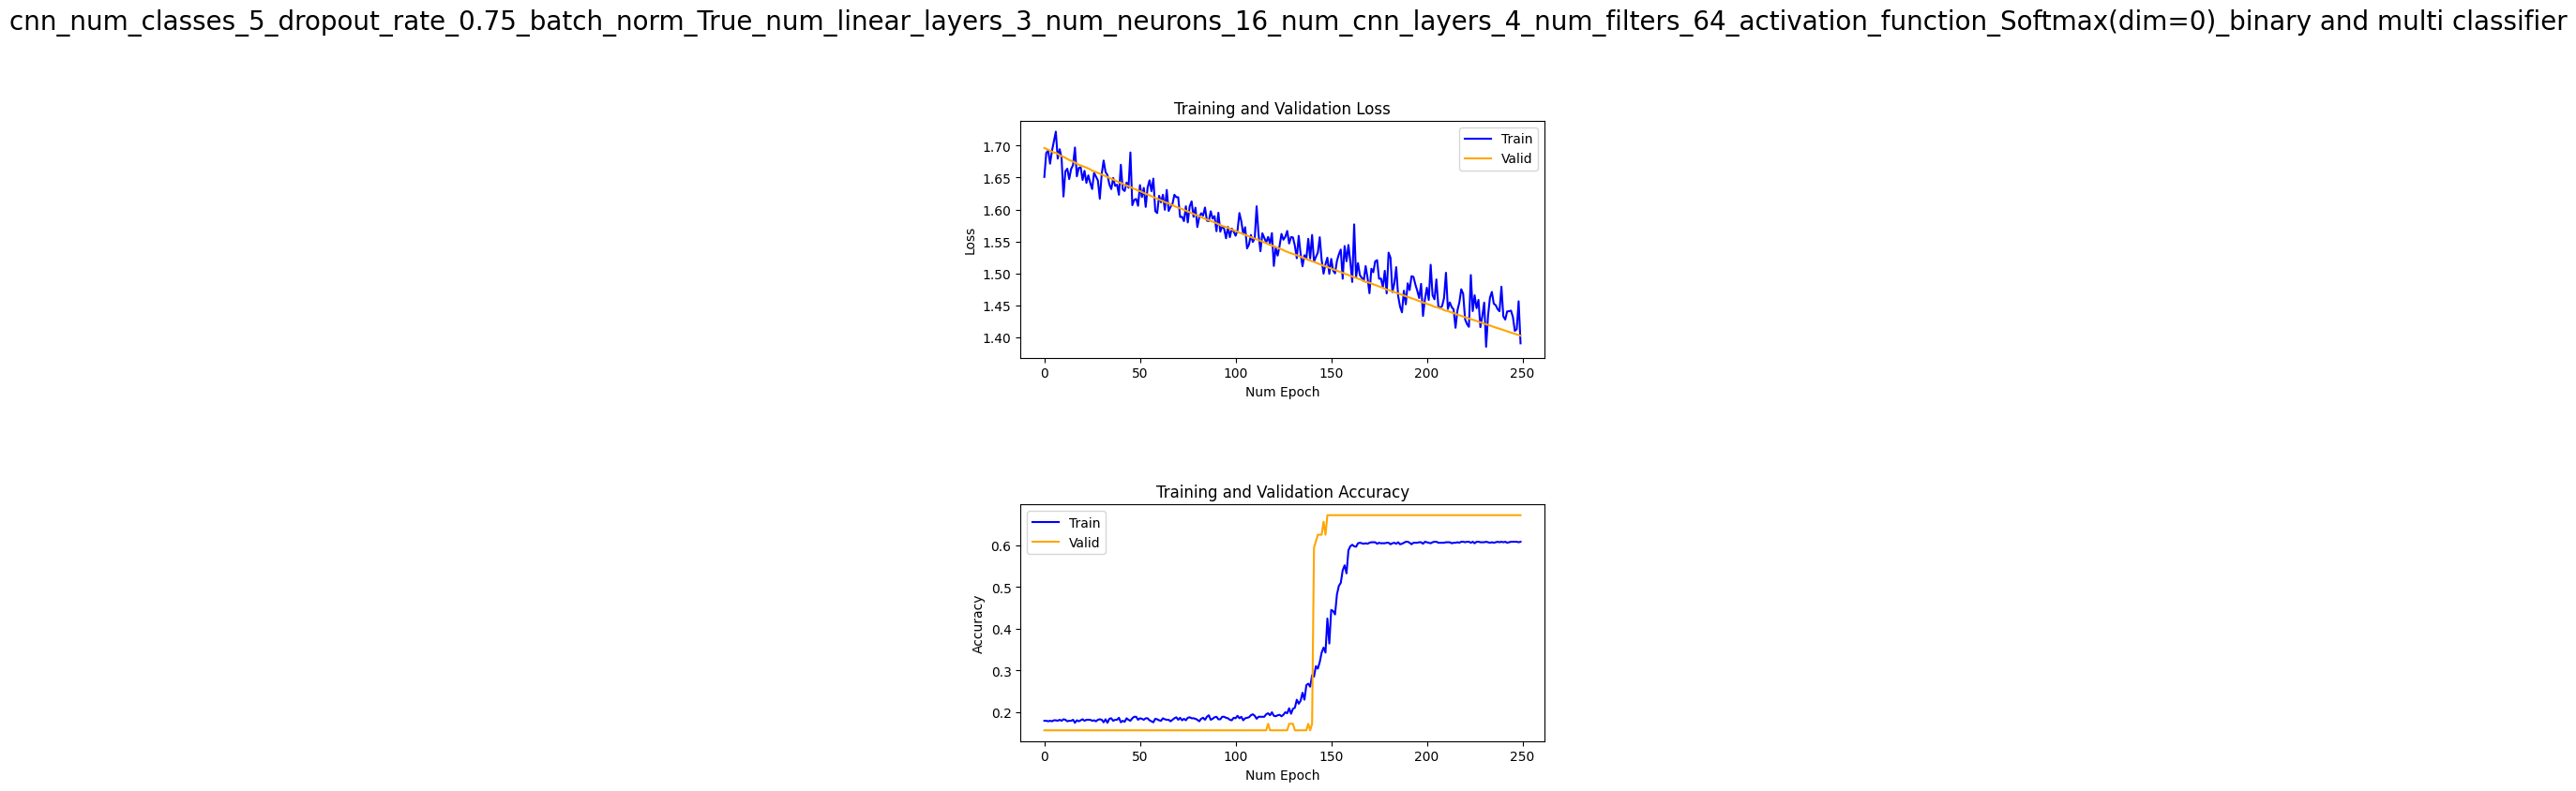

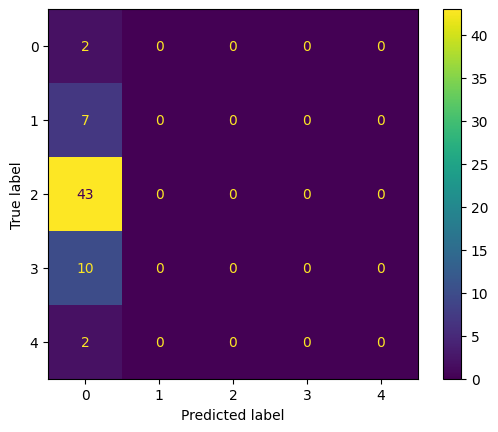

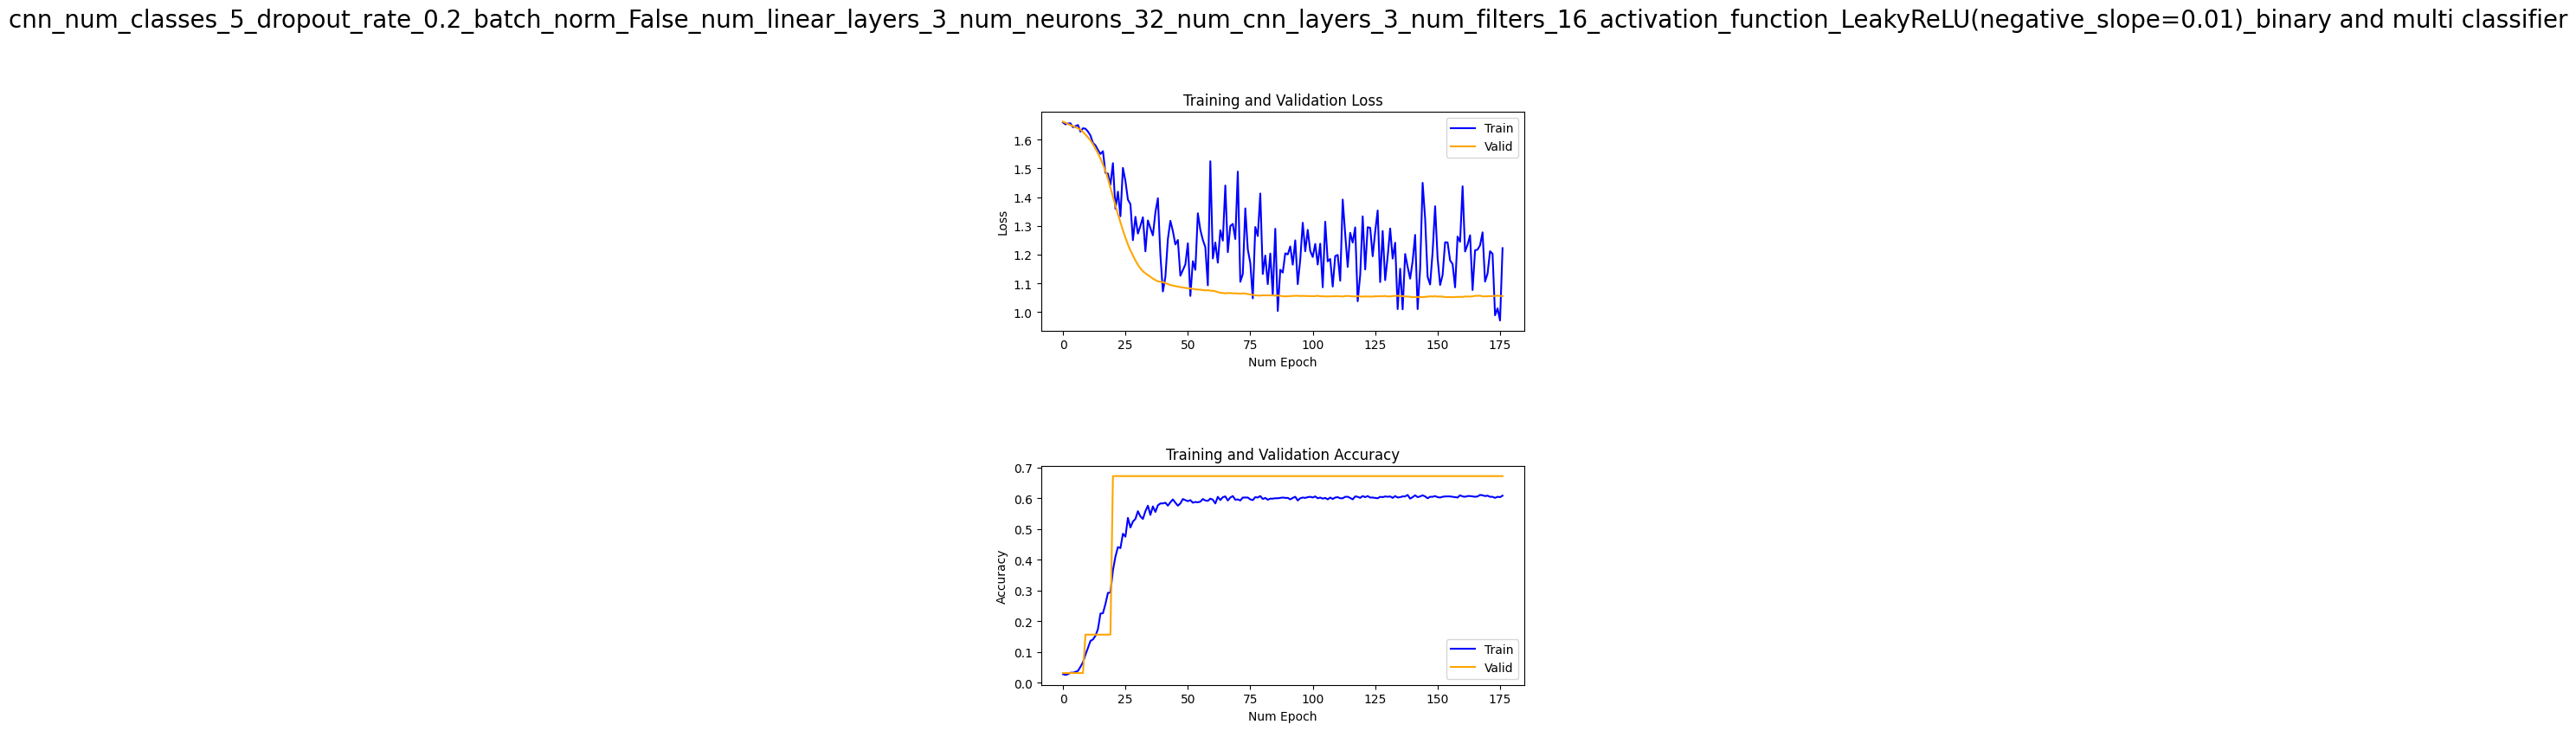

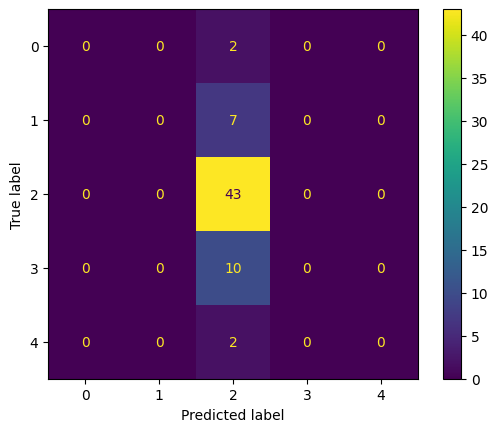

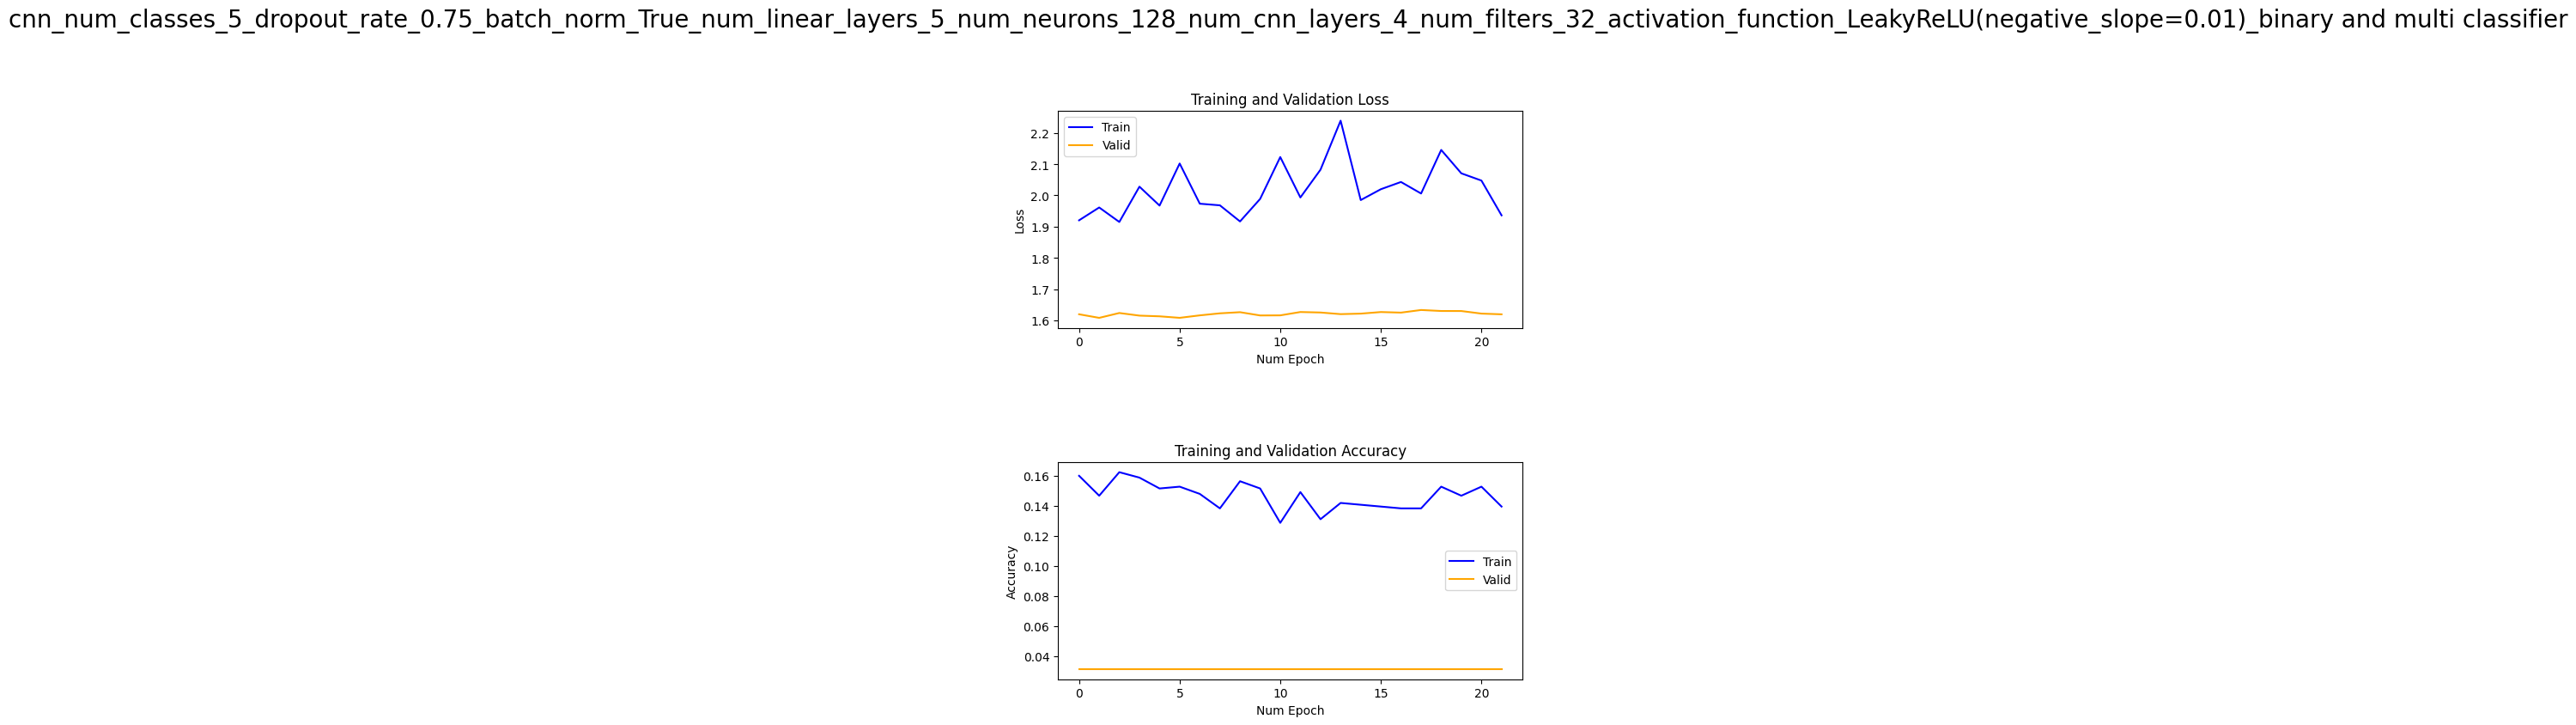

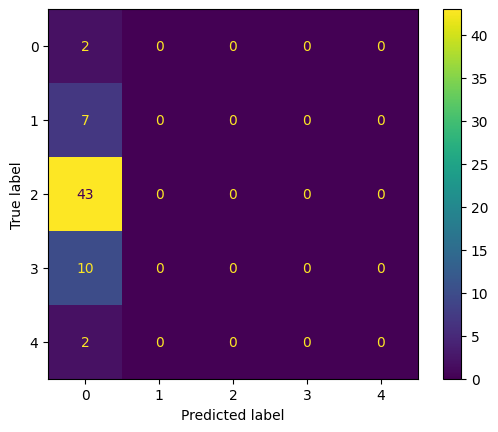

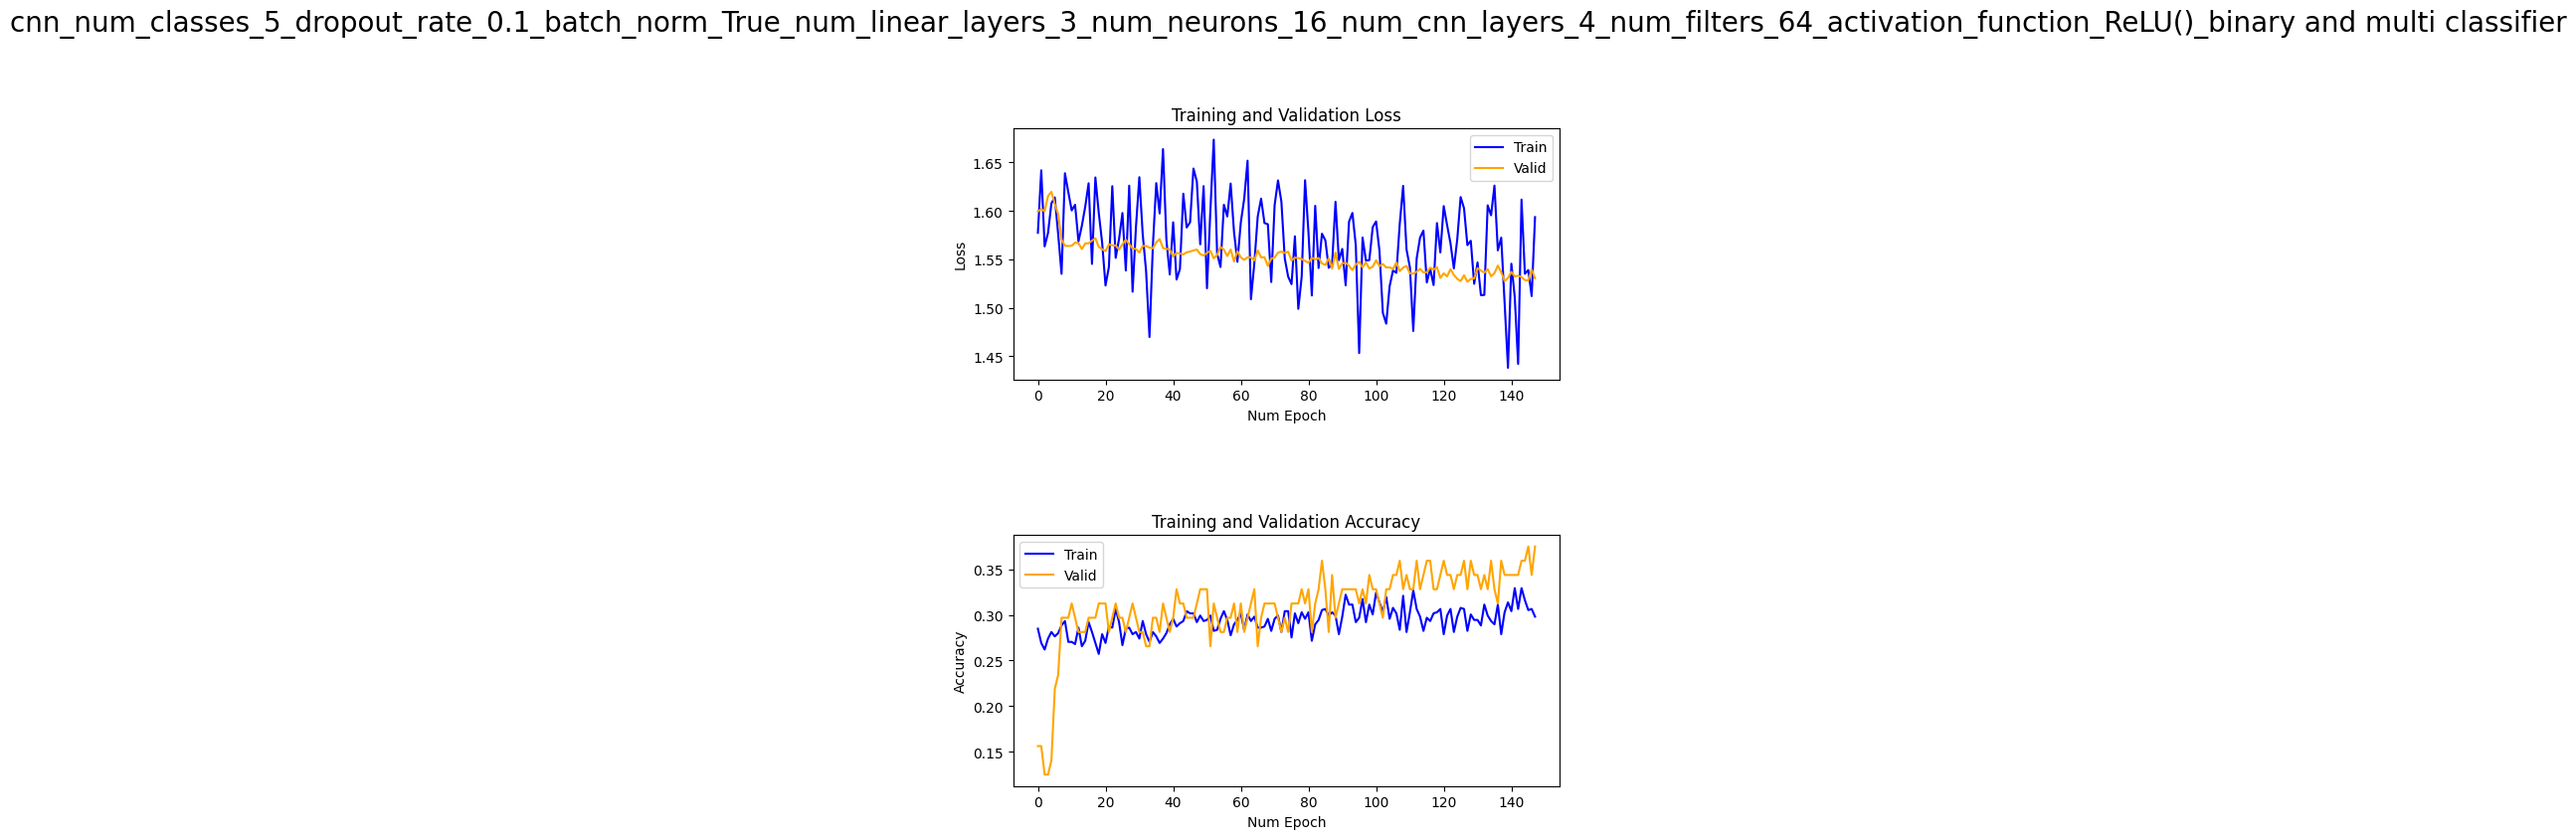

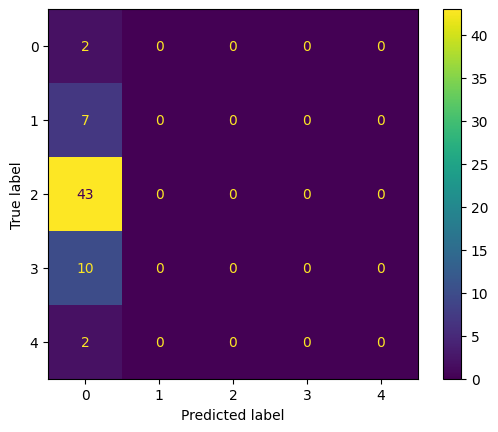

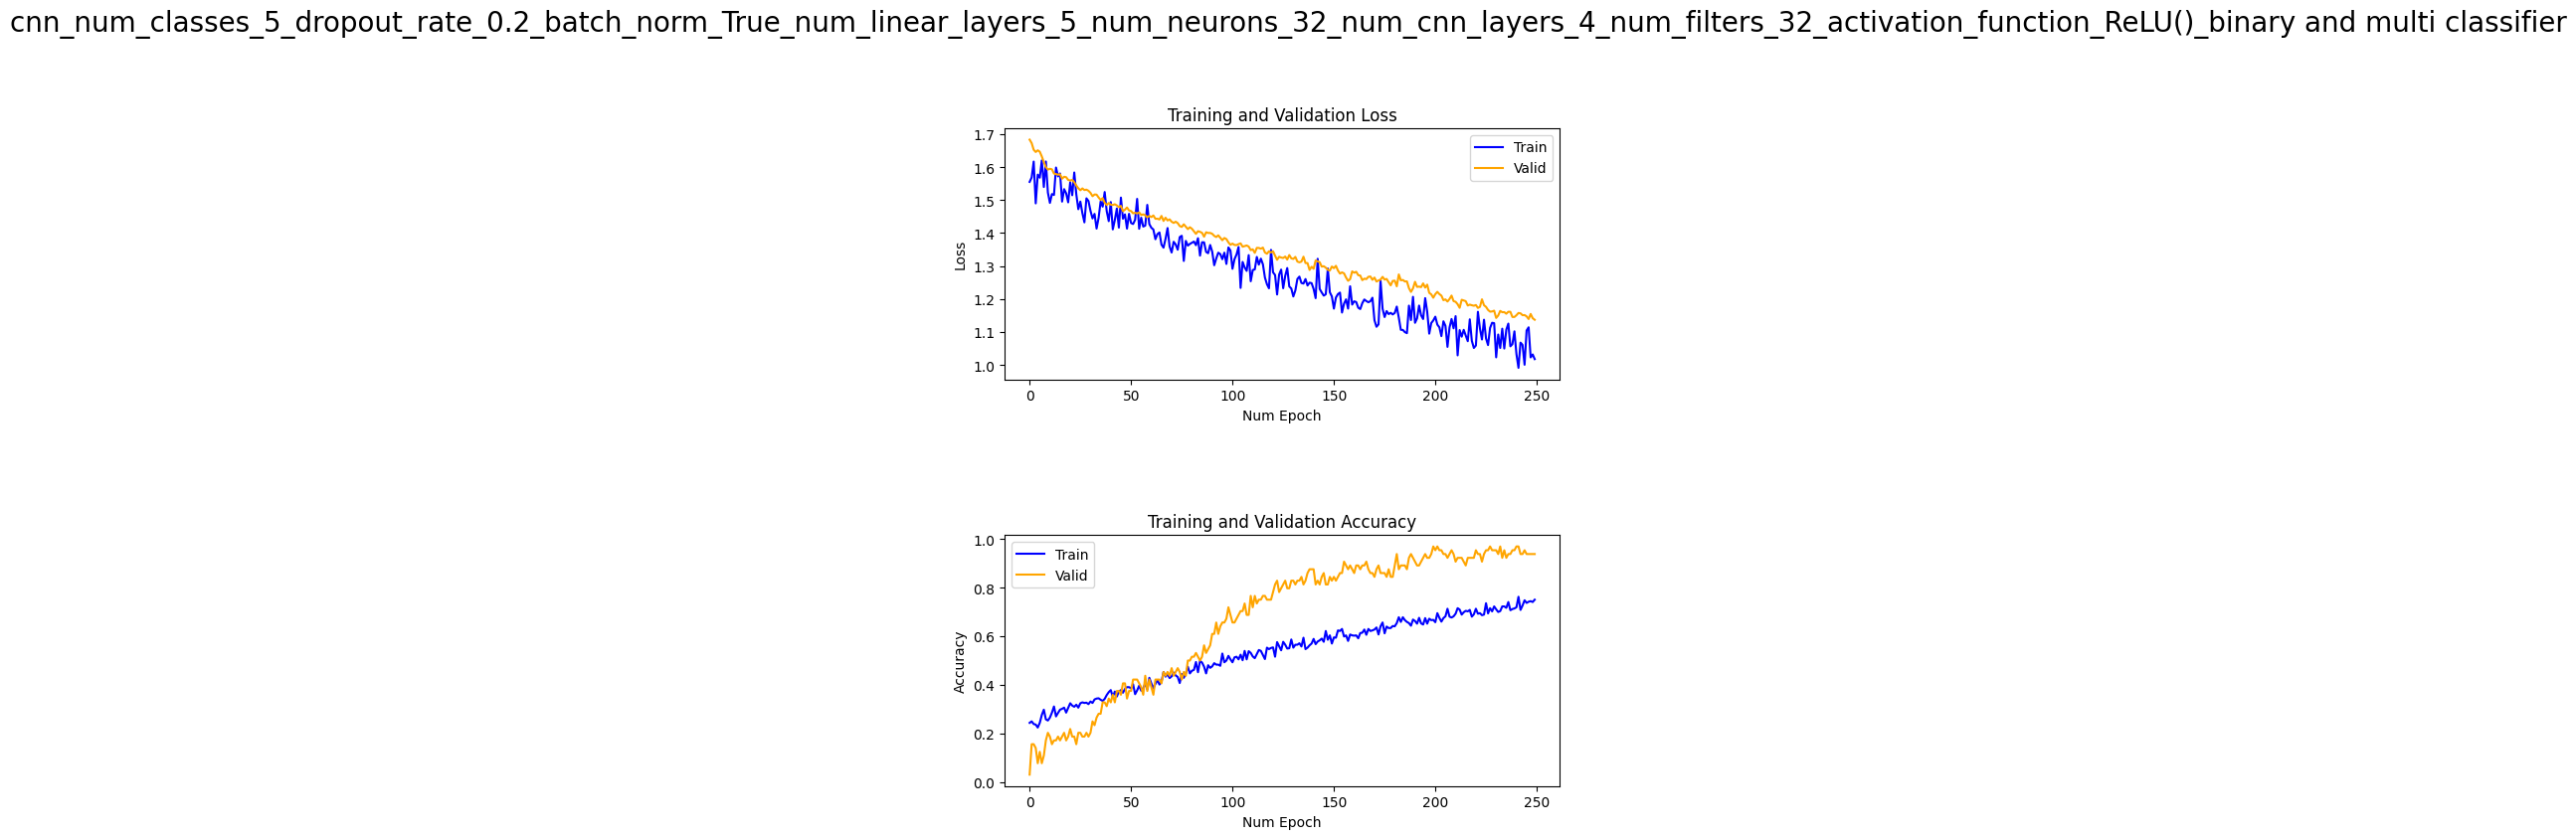

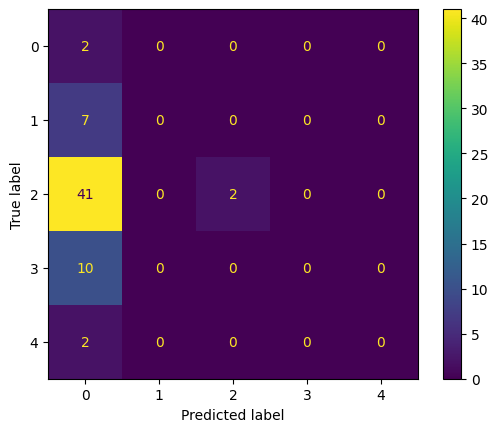

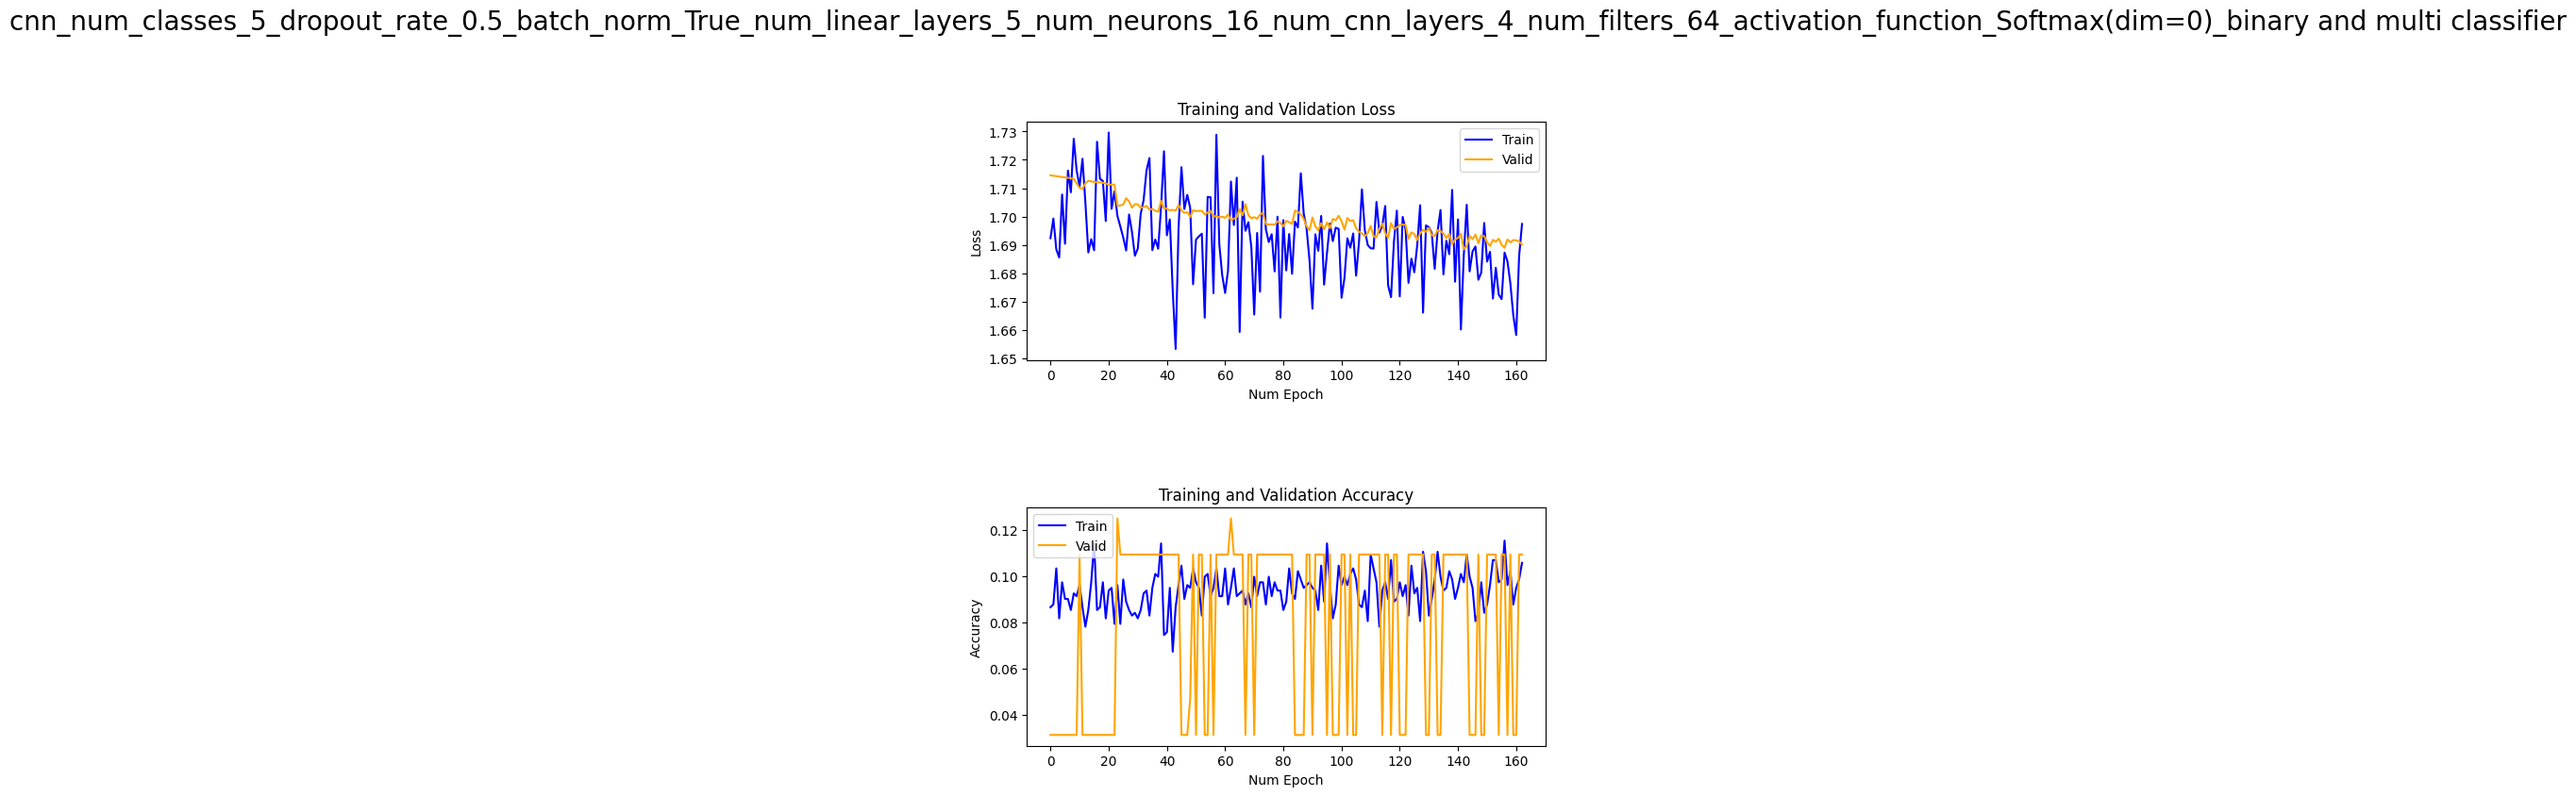

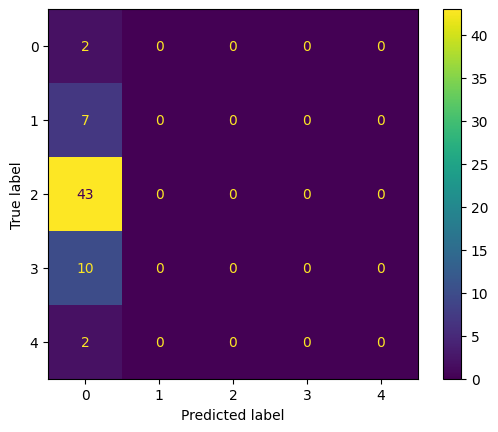

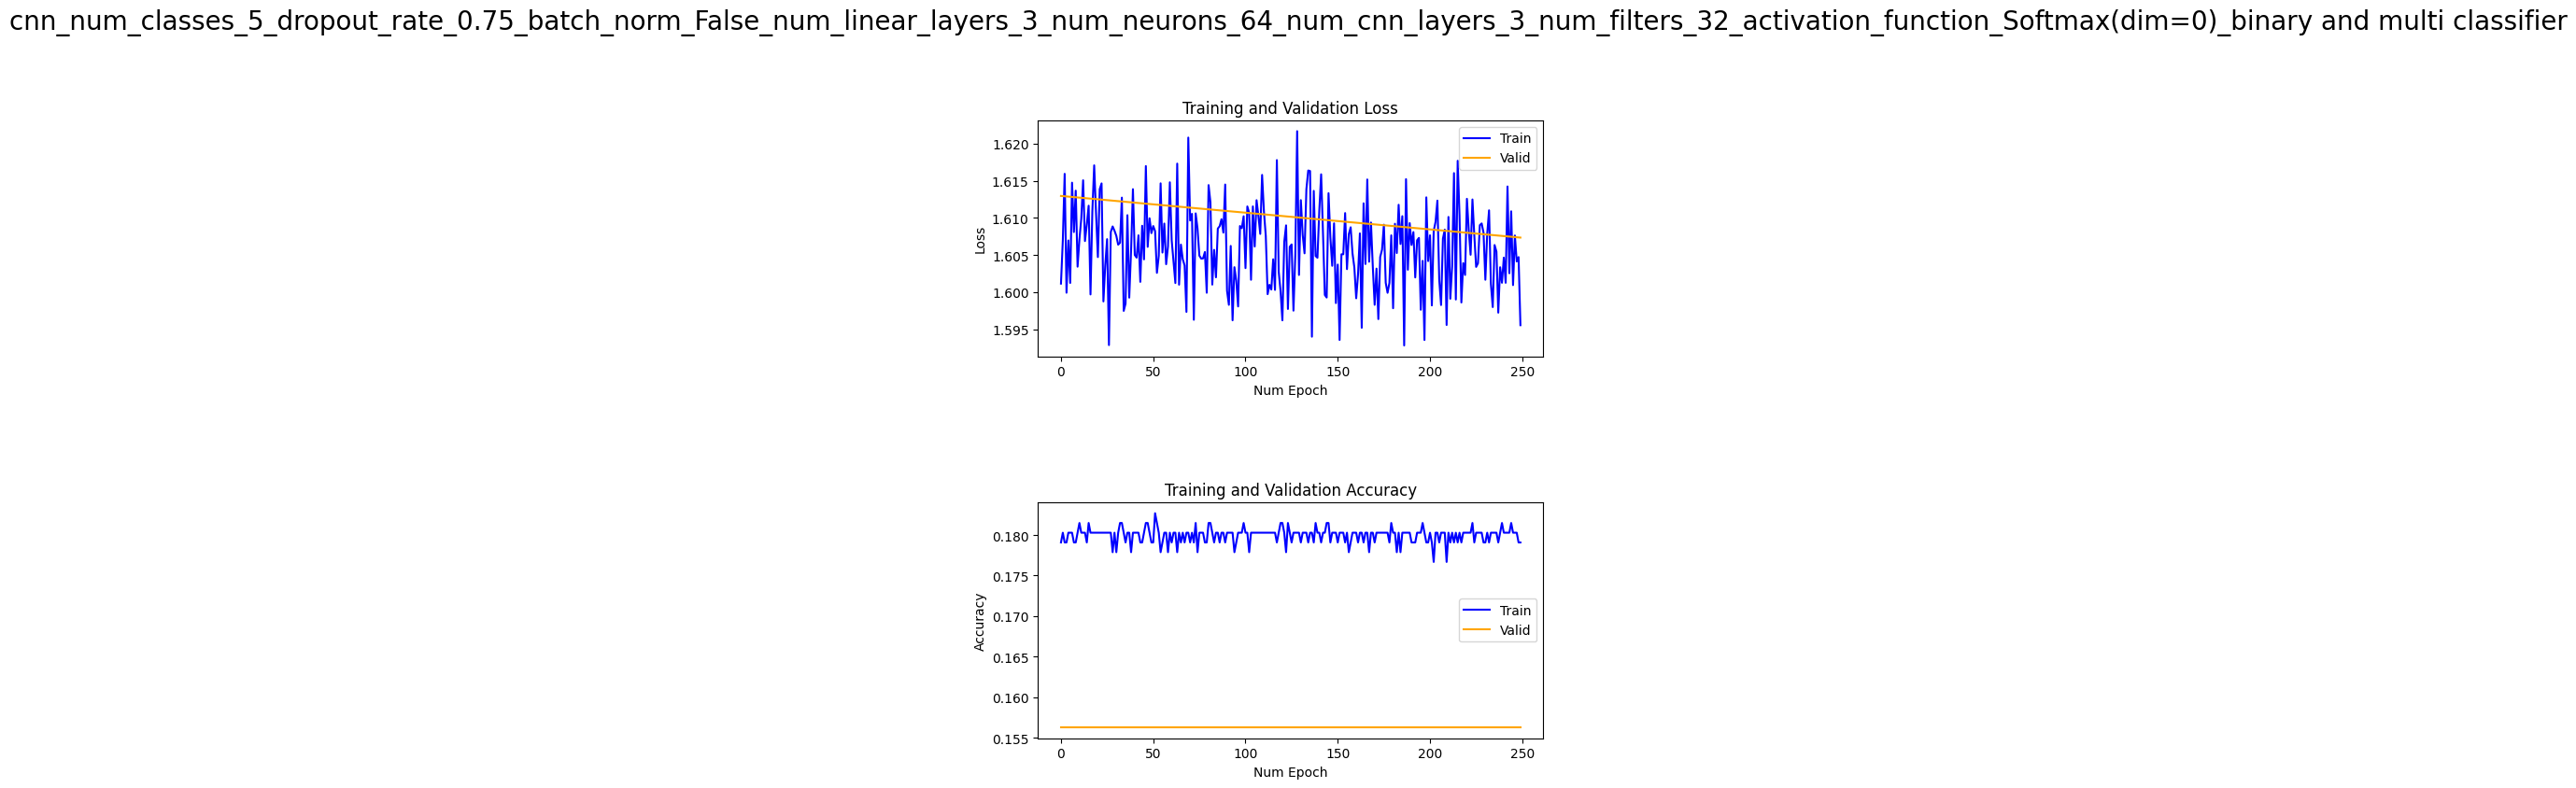

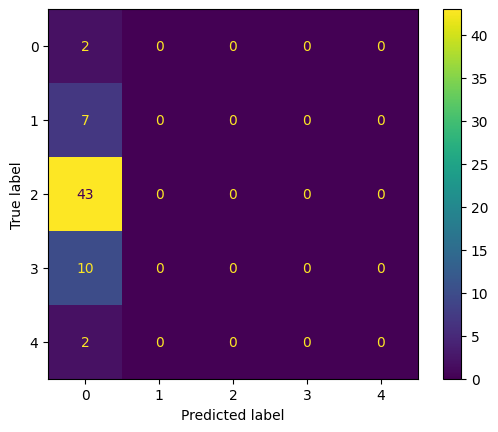

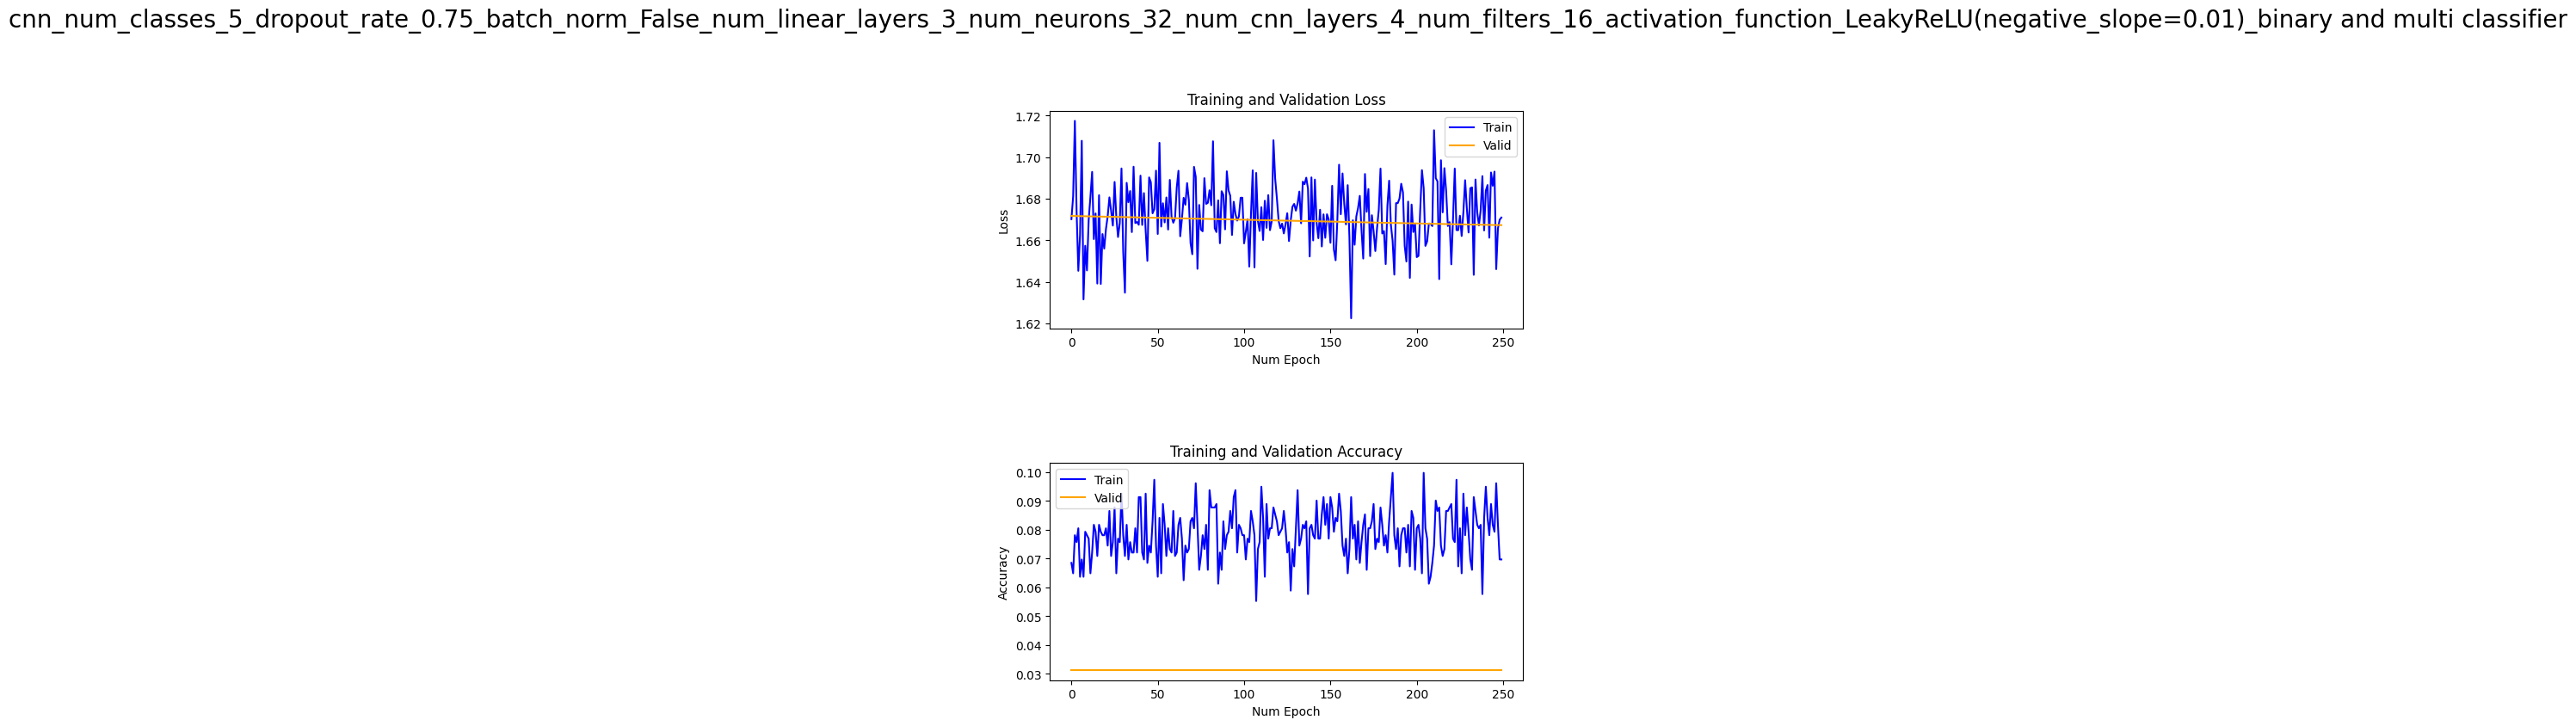

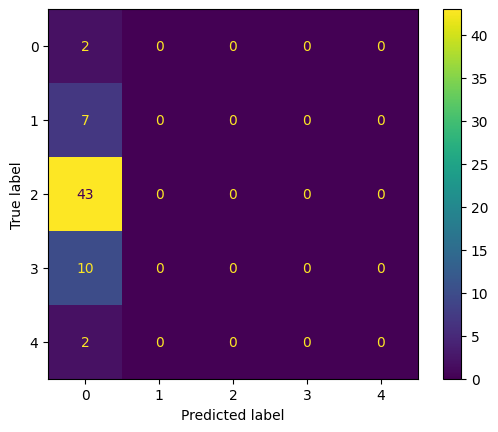

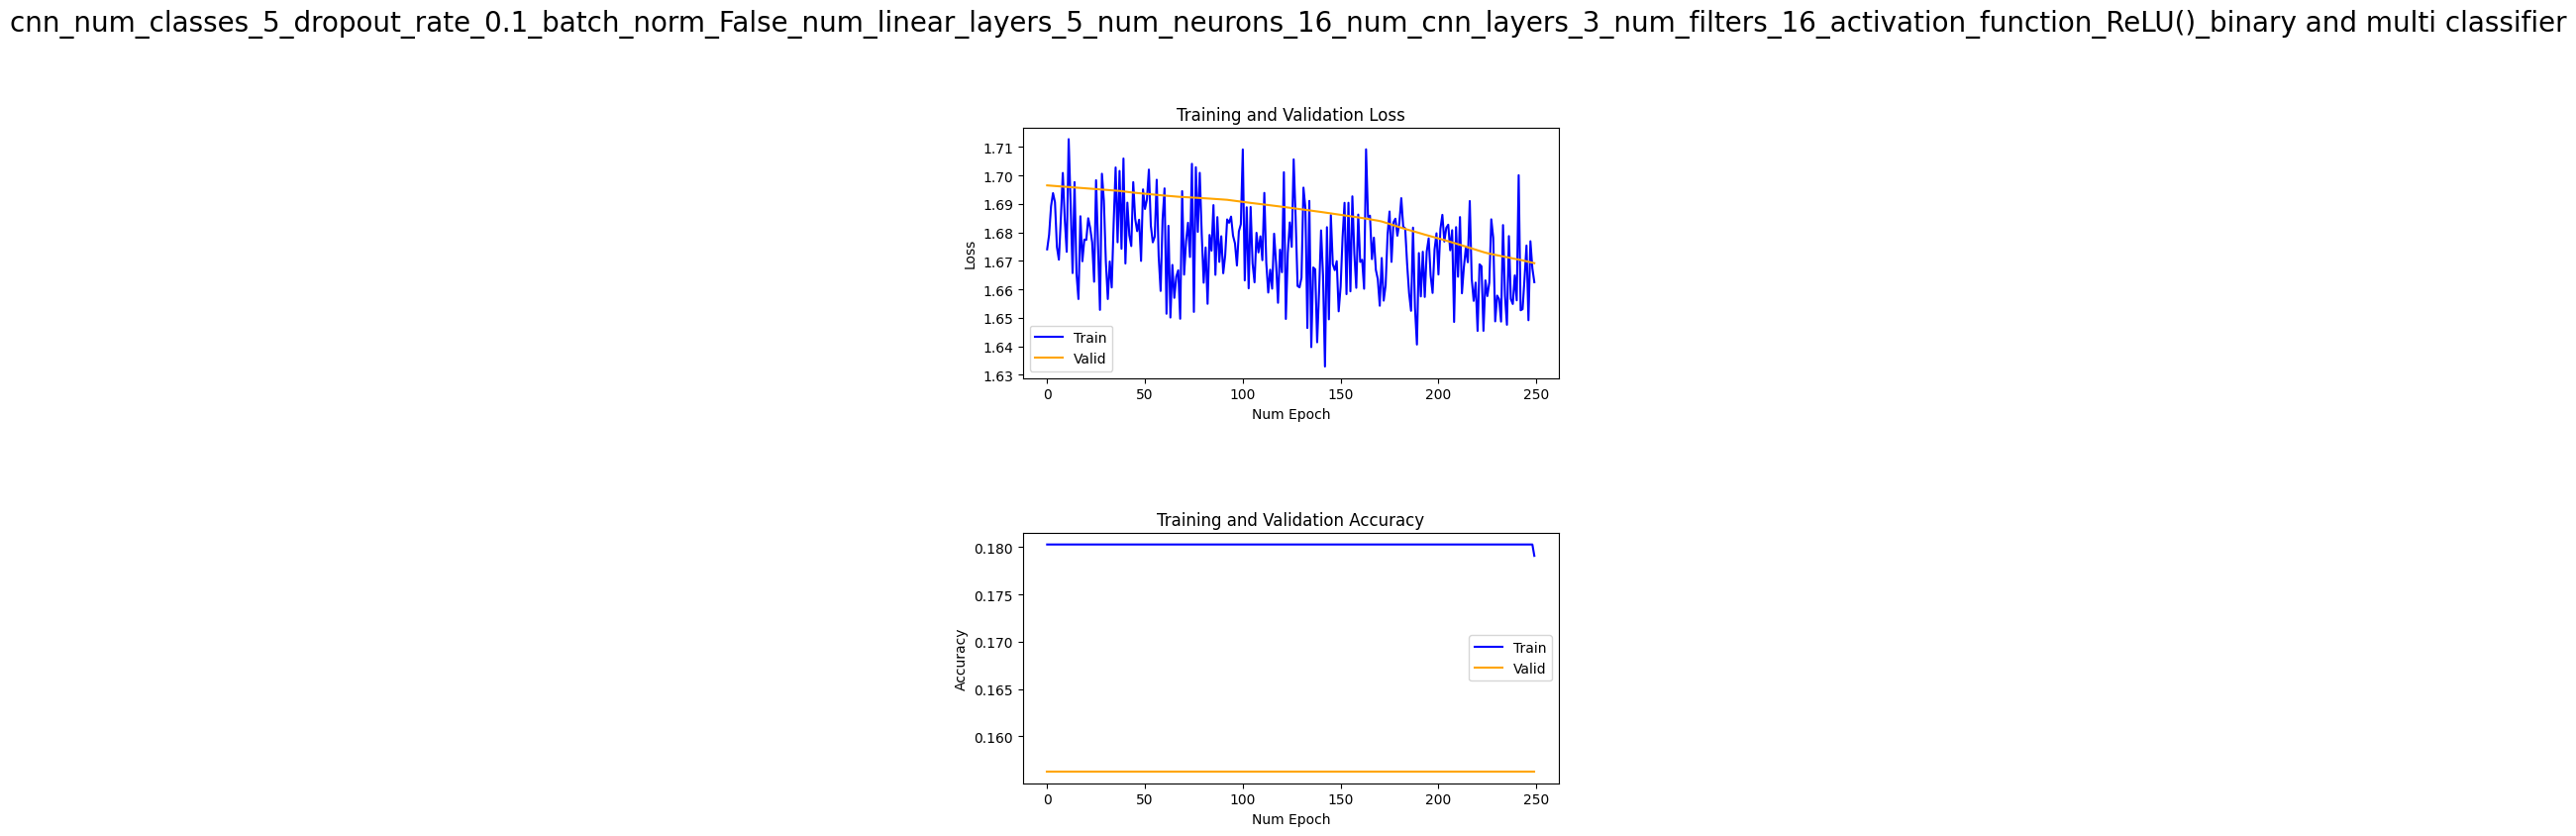

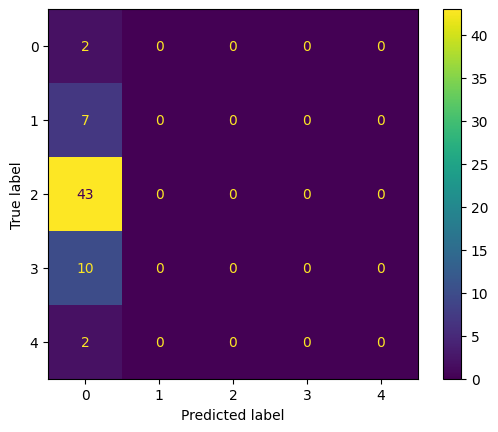

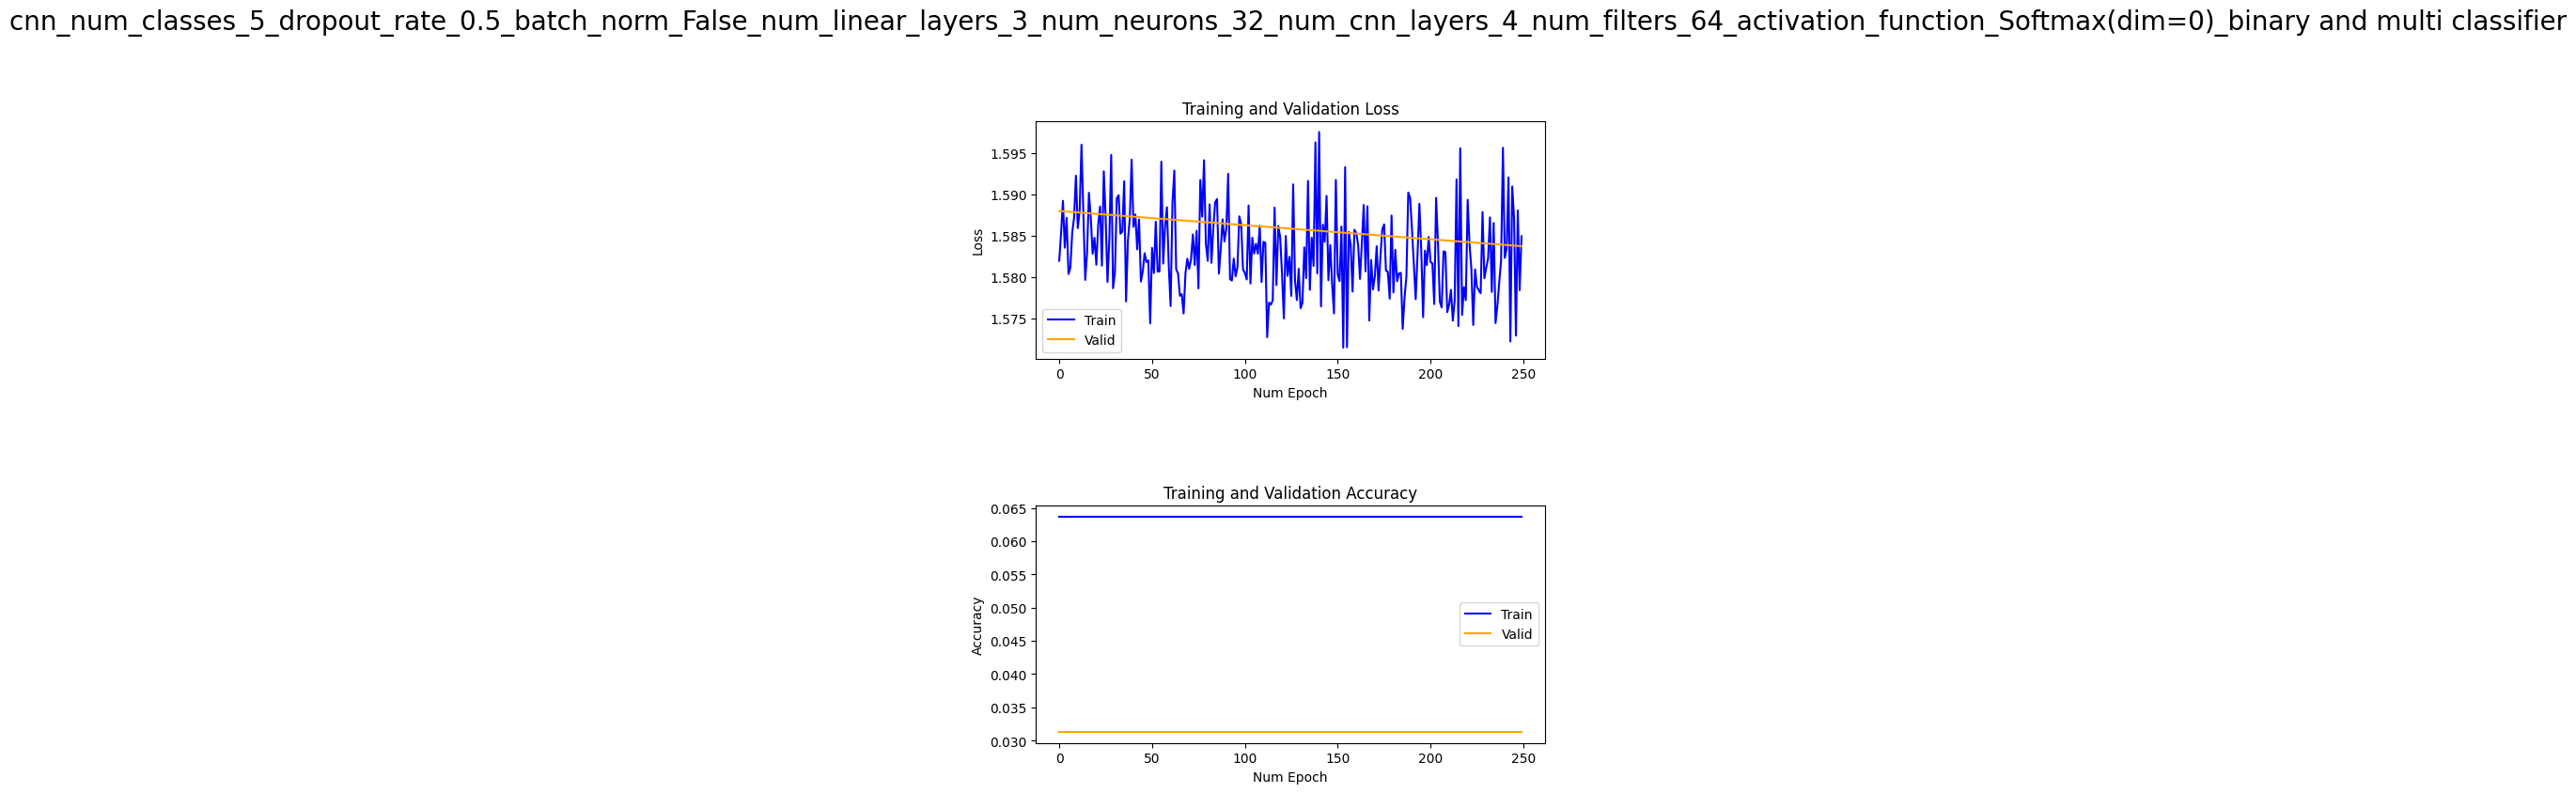

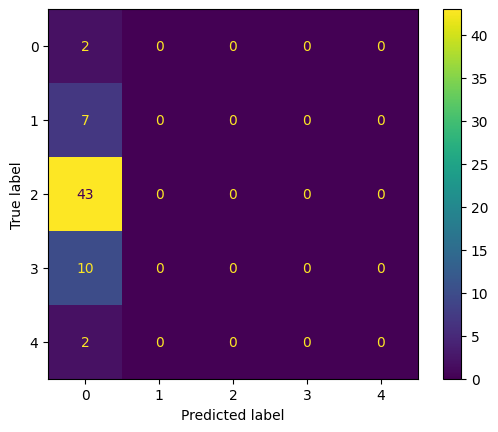

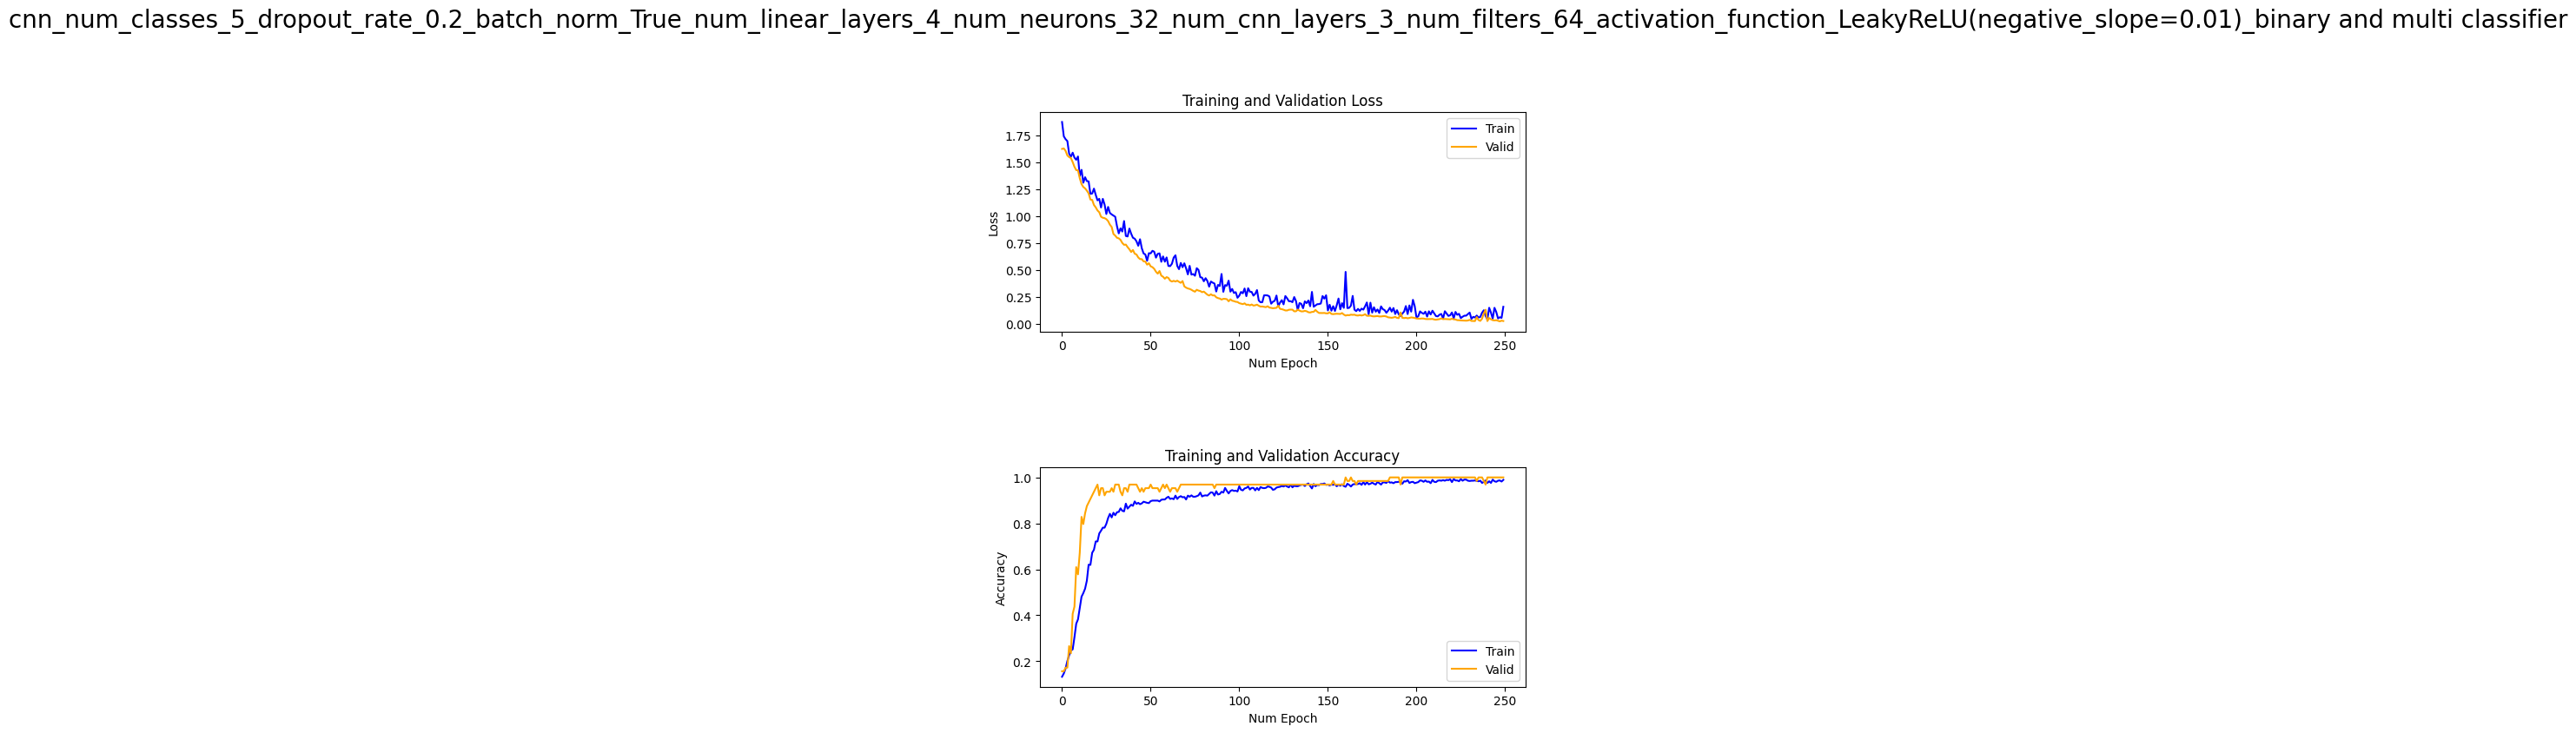

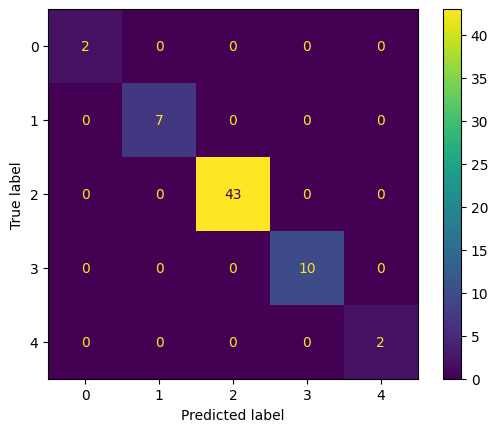

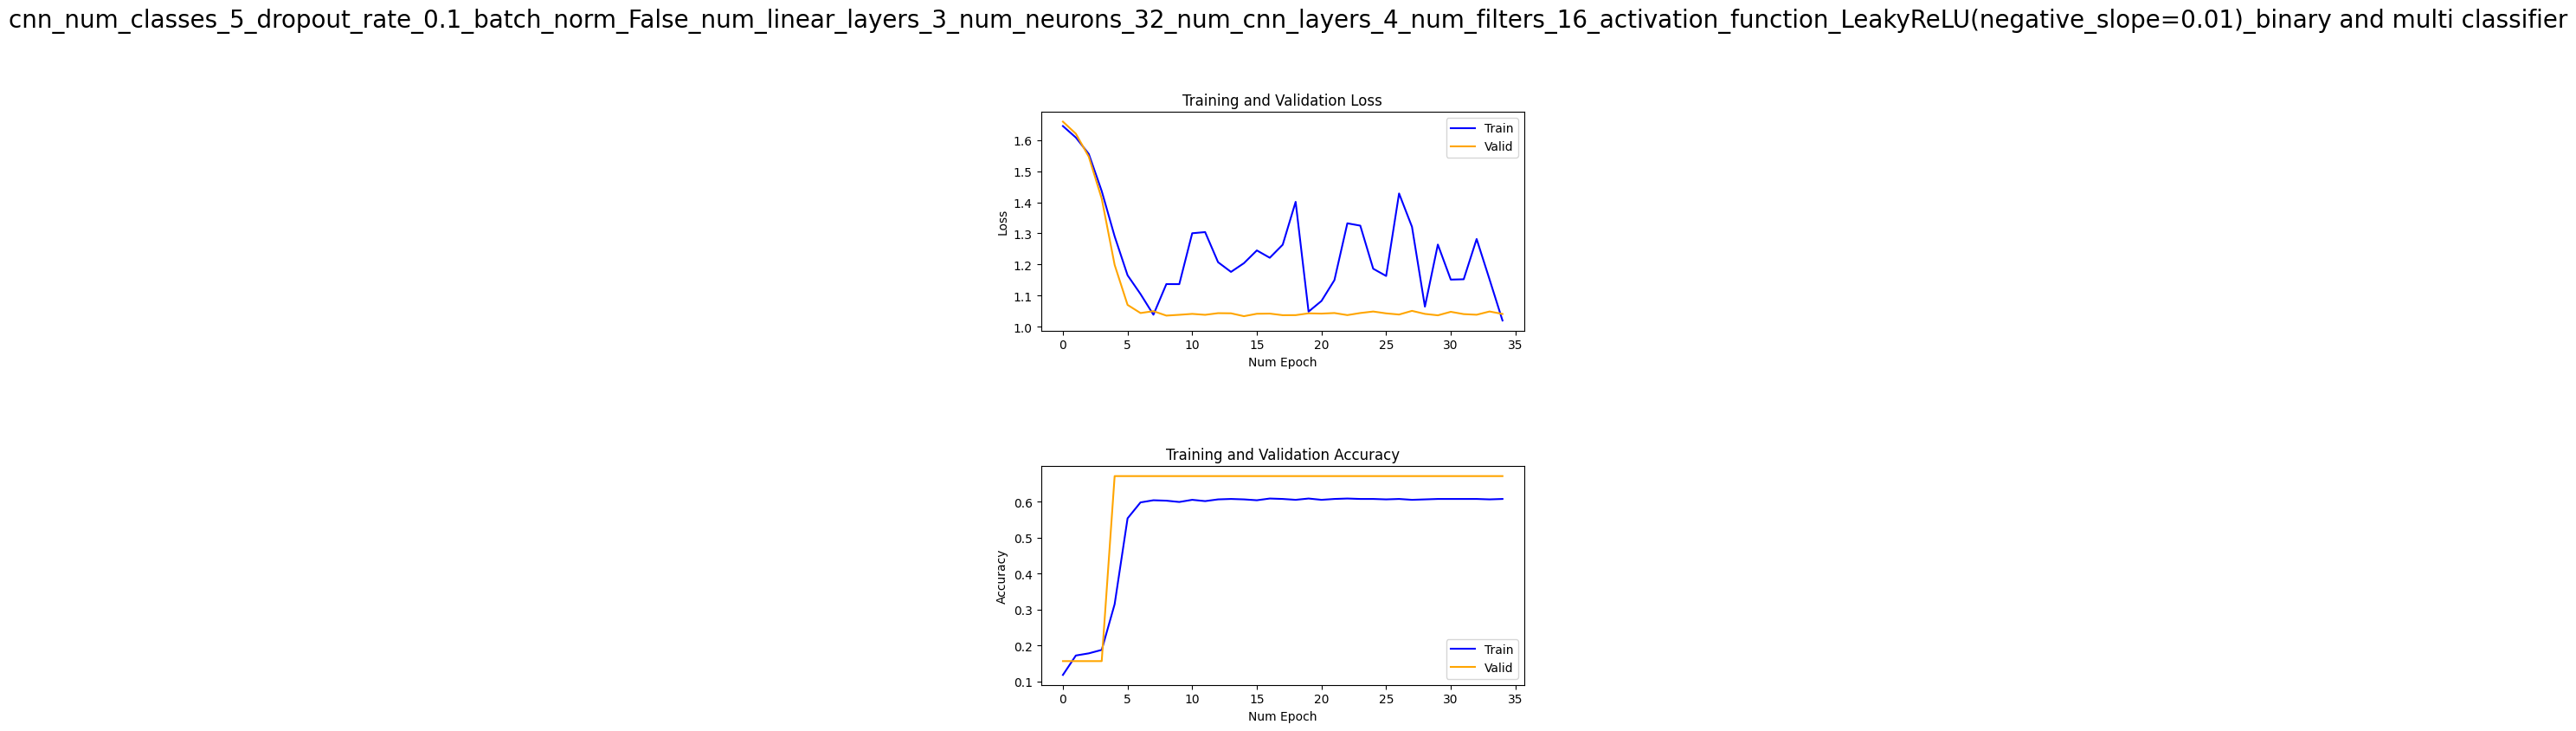

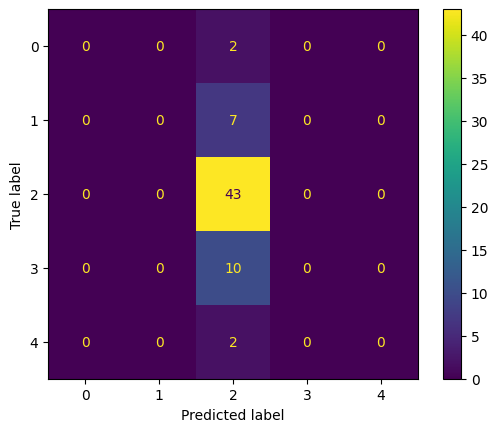

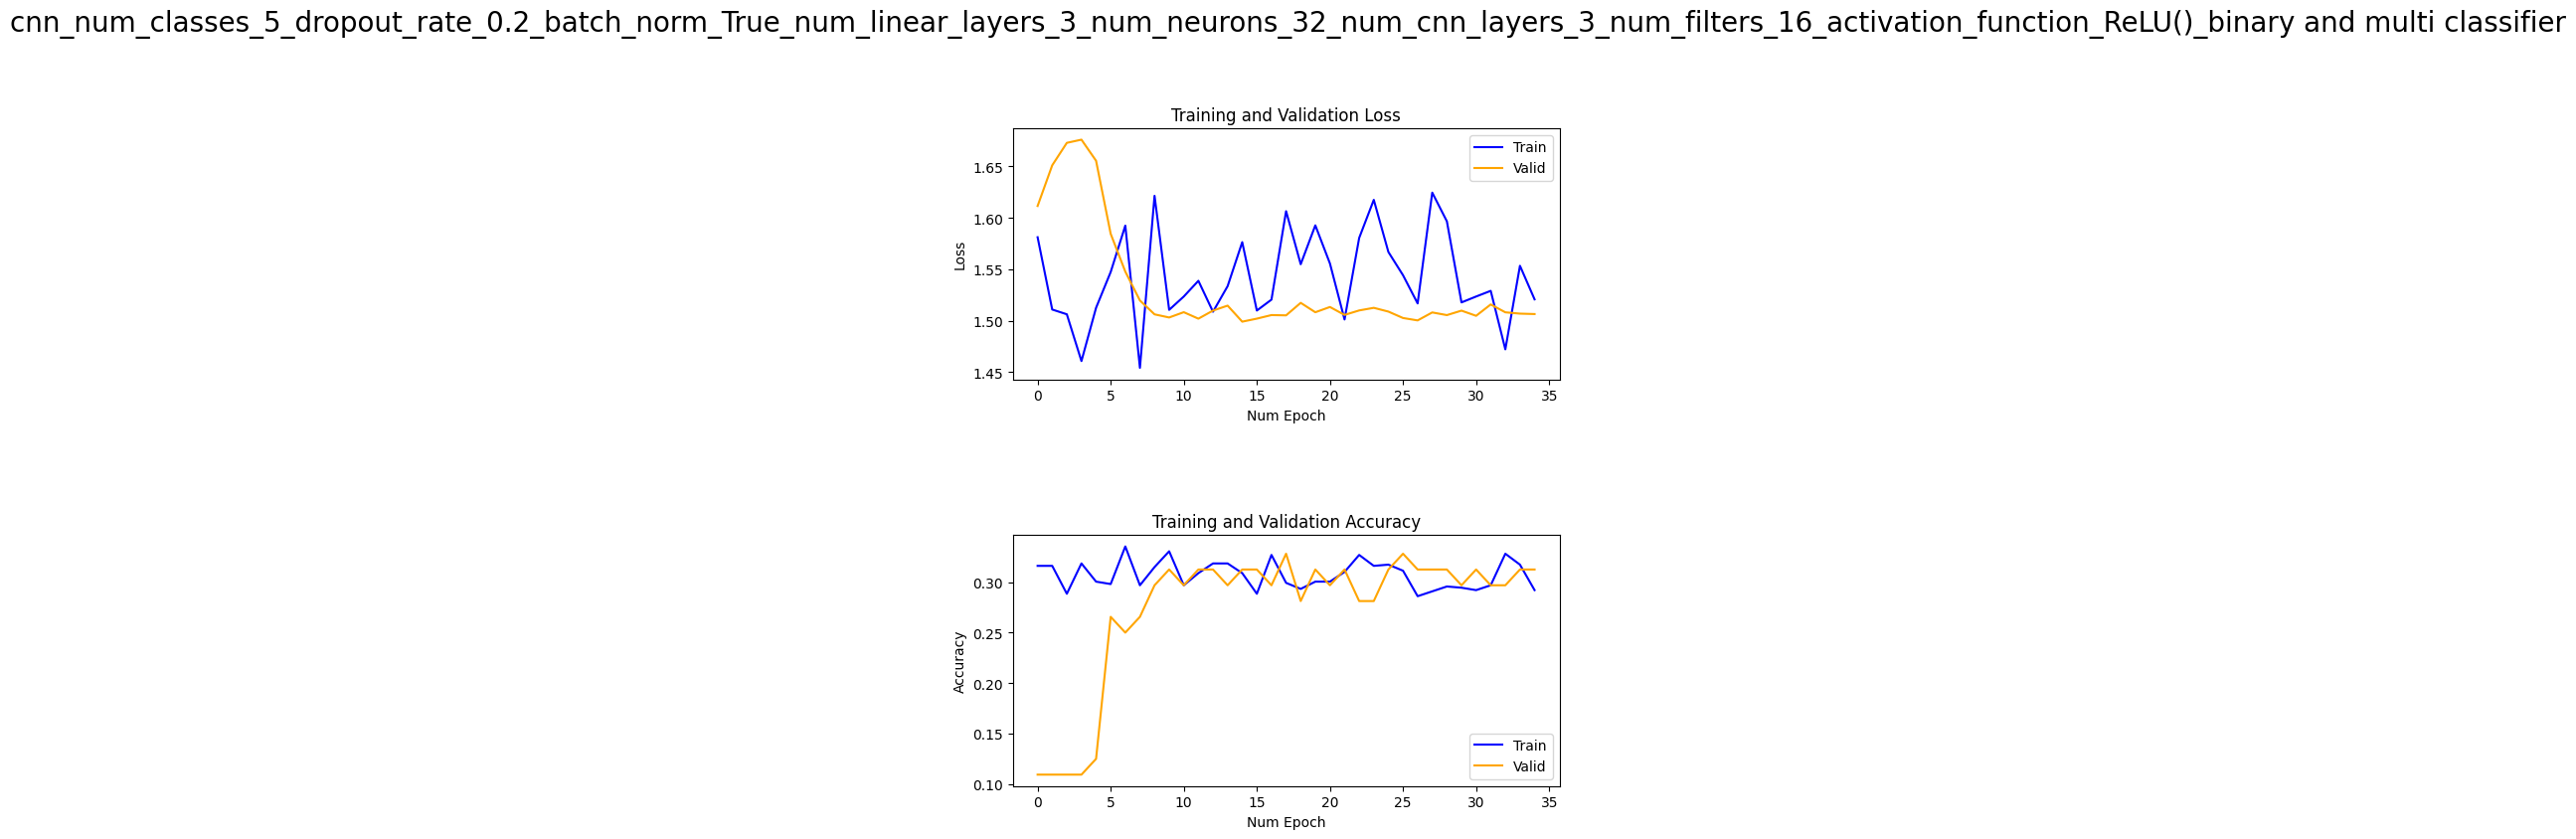

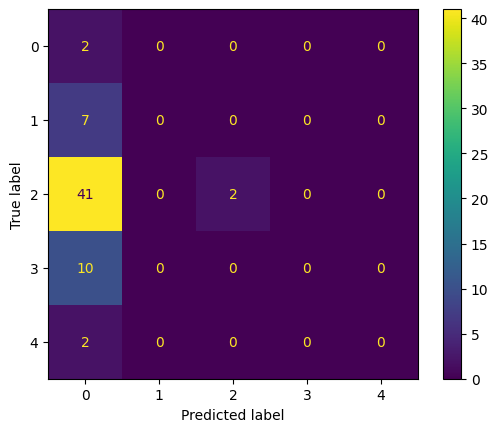

In [20]:
    best_test_model = random_grid_search(
    'binary and multi classifier'
    , lr_list
    , activation_function_list 
    , neuron_num_list 
    , batch_norm_list
    , dropout_rate_list
    , cnn_num_layers_list
    , linear_num_layers_list
    , filters_list
    , num_epochs
    , early_stop_num
    , num_classes
    , num_combos
    , seed_value)

## Submission

In [21]:
# best binary classifier
cnn_binary = CNN(cnn_num_classes=5, dropout_rate=.2, batch_norm=False, num_linear_layers=3, num_neurons=32, num_cnn_layers=3, num_filters=16, activation_function=nn.LeakyReLU(), pretrained_embedding=True, binary=True)
cnn_binary.to(device) 
cnn_binary.load_state_dict(torch.load(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\cnn_num_classes_5_dropout_rate_0.2_batch_norm_False_num_linear_layers_3_num_neurons_32_num_cnn_layers_3_num_filters_16_activation_function_LeakyReLU(negative_slope=0.01)_binary and multi classifier_binary', weights_only=True))

<All keys matched successfully>

In [22]:
# best multi classifier
cnn_multi = CNN(cnn_num_classes=5, dropout_rate=.2, batch_norm=True, num_linear_layers=4, num_neurons=32, num_cnn_layers=3, num_filters=64, activation_function=nn.LeakyReLU(), pretrained_embedding=True, binary=False)
cnn_multi.to(device)
cnn_multi.load_state_dict(torch.load(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\model_weights\cnn_num_classes_5_dropout_rate_0.2_batch_norm_True_num_linear_layers_4_num_neurons_32_num_cnn_layers_3_num_filters_64_activation_function_LeakyReLU(negative_slope=0.01)_binary and multi classifier_multi', weights_only=True))

<All keys matched successfully>

In [23]:
encoded_test = tokenizer.texts_to_sequences(test.text)

# pad sequences
test_copy = pad_sequences(encoded_test, maxlen=max_length, padding='post')
test_copy = torch.tensor(test_copy, dtype=torch.int).to(device)

In [24]:
test_copy.shape

torch.Size([979, 200])

In [25]:
cnn_binary.eval()
with torch.no_grad():
    outputs = cnn_binary(torch.tensor(test_copy))
    binary_ouputs = torch.argmax(outputs, dim=1)

C:\Users\connor\AppData\Local\Temp\ipykernel_27492\436039378.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = cnn_binary(torch.tensor(test_copy))


In [26]:
additional_input = binary_ouputs.view([len(binary_ouputs), 1])
# test_temp = test[0: len(additional_input), :].view([len(additional_input), -1])
print(test_copy.shape)
print(binary_ouputs.shape)
print(binary_ouputs.unique())
test_additional_input = torch.cat([test_copy, additional_input], dim=1)
print(test_additional_input.shape)
# augmented_train_dataloader = TensorDataset(test_additional_input, y_train[0: len(test_additional_input)])
# test_loader = DataLoader(augmented_train_dataloader, batch_size=batch_size, shuffle=True, drop_last=False)

torch.Size([979, 200])
torch.Size([979])
tensor([0], device='cuda:0')
torch.Size([979, 201])


In [27]:
cnn_multi.eval()
with torch.no_grad():
    outputs = cnn_multi(test_additional_input, augmented_input=True)
    multi_outputs = torch.argmax(outputs, dim=1)
    print(multi_outputs)

tensor([2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 1, 2,
        2, 2, 3, 1, 2, 3, 1, 2, 2, 4, 4, 2, 2, 1, 2, 3, 3, 2, 2, 2, 4, 2, 3, 2,
        2, 3, 2, 2, 4, 2, 4, 2, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 2, 4, 2,
        2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 2, 1, 4, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 2,
        2, 4, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 0, 1, 2,
        2, 4, 4, 2, 1, 2, 2, 2, 4, 2, 2, 3, 3, 1, 2, 2, 2, 2, 2, 2, 2, 4, 2, 2,
        2, 2, 1, 2, 3, 2, 2, 4, 1, 3, 2, 1, 2, 3, 1, 3, 2, 2, 4, 1, 2, 2, 1, 1,
        2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 2, 3, 2, 2, 2, 1,
        2, 2, 2, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 0, 3, 2, 2, 2, 2, 2, 3, 2, 2, 3,
        2, 2, 3, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 2, 2, 4, 3, 2, 3, 2, 2, 2, 2,
        2, 2, 4, 2, 2, 3, 4, 2, 2, 2, 2,

In [28]:
multi_outputs = multi_outputs.to('cpu')
predictions = pd.DataFrame(multi_outputs.numpy())
predictions.columns = ['sentiment']
predictions['id'] = predictions.index
predictions = predictions[['id', 'sentiment']]
predictions.id = [x + 1 for x in predictions.id]
predictions.sentiment = [x + 1 for x in predictions.sentiment]
predictions.reset_index(drop=True, inplace=True)
predictions.to_csv(r'C:\Users\connor\PycharmProjects\portfolio\sentiment_analysis_cnn\predictions.csv')